<a href="https://colab.research.google.com/github/iceaiai/CS-team/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python pillow
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=86c52b150a15093223e81e6dbe76fea19e7c5944dd888dfeebe57a63beb732b8
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=e36c1b52cd0c84f5df8deb16c9ab5e65549e009fa65079699921872b68ea1695
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

#1. Setup and Imports
Import all necessary libraries and ensure that the environment is correctly set up

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.transforms import *
from PIL import Image
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import torch.optim as optim
from torchvision import transforms, models
import os
import numpy as np
import kagglehub
import shutil


original_path = kagglehub.dataset_download("batuhanyil/electron-microscopy-particle-segmentation")
print("Original Path to dataset files:", original_path)
path = "/content/electron-microscopy-particle-segmentation"
shutil.move(original_path, path)
print(f"Dataset moved to: {path}")
!ls {path}

100%|██████████| 113M/113M [00:06<00:00, 17.5MB/s]

Extracting files...


Original Path to dataset files: /root/.cache/kagglehub/datasets/batuhanyil/electron-microscopy-particle-segmentation/versions/1
Dataset moved to: /content/electron-microscopy-particle-segmentation
images	segmaps


In [3]:
print("Contents of the dataset folder:")
print(os.listdir(path))

Contents of the dataset folder:
['images', 'segmaps']


#2.Configuration class or dictionary to make hyperparameters easily tunable
Note: 'image' folder contains SEM/TEM images. 'segmaps' contained the labelled masks.They are also available in our GT github.

In [4]:
class Config:
    # Data parameters
    image_folder = os.path.join(path, 'images')
    mask_folder = os.path.join(path, 'segmaps')
    resize = (512, 512) # it will be very painful if the image height and width are not the same!!!!

    # Training hyperparameters
    num_epochs = 100
    batch_size = 16
    learning_rate = 2e-4
    momentum = 0.9
    weight_decay = 1.5e-4

    # Model parameters
    num_classes = 1  # For binary segmentation
    kernel_size = 3
    stride = 1
    padding = 1

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f'current device = {config.device}')


current device = cuda


#3. Dataset preparation:


In [5]:
#Class for preparing data
class ImageDataset:
    def __init__(self, image_folder, mask_folder,transform =None,binary=False):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.image_files = sorted(os.listdir(image_folder))
        self.mask_files = sorted(os.listdir(mask_folder))
        self.transform = transform
        self.binary = binary
    def binary_transform(self, mask): # We only deal with one class
        # Transform mask to 1,0. 1 for masked area, 0 for not
        mask_array = np.array(mask)
        binary_mask = (mask_array != 0).astype(np.uint8)
        return Image.fromarray(binary_mask)

    def __len__(self): #Dunder method, usage: len(obj)
      return len(self.image_files)
    def __getitem__(self, idx): #Dunder method, usage: obj[idx]
      image_path = os.path.join(self.image_folder, self.image_files[idx])
      mask_path = os.path.join(self.mask_folder, self.mask_files[idx])
      image = Image.open(image_path).convert('L')
      mask = Image.open(mask_path).convert('L')
      if self.binary:
          mask = self.binary_transform(mask)
      if self.transform:
          image, mask = self.transform(image, mask)
      return image, mask
    def plot_figure(self, overlay=False, mask=True, binary=False, idx=None):
        """
        overlay: overlapping the original and masked images
        mask: display mask images
        idx: index or list of indices of the images to plot
        """
        if idx is None:
            idx = [0]
        elif isinstance(idx, int):
            idx = [idx]
        idx = [i for i in idx if i < len(self.image_files)]
        total_cols = 3 if mask and overlay else 2 if mask else 1
        total_rows = len(idx)
        fig, axes = plt.subplots(total_rows, total_cols, figsize=(5 * total_cols, 5 * total_rows))

        if total_rows == 1:
            axes = [axes]

        for i, file_idx in enumerate(idx):
            img, mask_img = self[file_idx]

            # Convert tensors to numpy arrays
            img_np = img.squeeze(0).numpy()  # Squeeze channel for grayscale
            mask_np = mask_img.numpy()  # mask is already single-channel after transform

            ax_row = axes[i] if total_rows > 1 else axes

            # Display the image
            ax_row[0].imshow(img_np, cmap='gray')
            ax_row[0].set_title(f"Image {self.image_files[file_idx]}")
            ax_row[0].axis('off')

            if mask:
                # Display the mask
                ax_row[1].imshow(mask_np, cmap='inferno')
                ax_row[1].set_title(f"Mask {self.mask_files[file_idx]}")
                ax_row[1].axis('off')

                if overlay:
                    # Display the overlay
                    ax_row[2].imshow(img_np, cmap='gray', alpha=0.9)
                    ax_row[2].imshow(mask_np, cmap='inferno', alpha=0.4)
                    ax_row[2].set_title(f"Overlay {file_idx}")
                    ax_row[2].axis('off')

        plt.tight_layout()
        plt.show()

#Class for transforming data:
"""
  1. Resizing;
  2. Converting to tensor;
"""
class SegmentationTransform:
    def __init__(self, resize=None):
        self.resize = resize
        self.image_resize = transforms.Resize(resize)
        self.mask_resize = transforms.Resize(resize, interpolation=Image.NEAREST)

    def __call__(self, image, mask):
        image = self.image_resize(image)
        image_tensor = torch.tensor(np.array(image), dtype=torch.float32).unsqueeze(0) / 255.0
        mask = self.mask_resize(mask)
        mask_array = np.array(mask)
        binary_mask = (mask_array > 0).astype(np.float32)
        mask_tensor = torch.tensor(binary_mask)
        return image_tensor, mask_tensor




#4. Data Loader

In [6]:
#Assign image and mask folder. Test the imagedata set class:
transform = SegmentationTransform(resize = config.resize) # can add resize if needed but not recommended
dataset = ImageDataset(config.image_folder, config.mask_folder, transform=transform, binary=True)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Data loaders
"""
You can set:
batch size;
shuffle the data or not
num_workers: higher value speeding up the loading process.

"""

train_loader = DataLoader(train_dataset,
              batch_size=config.batch_size,
              shuffle=True,
              num_workers=4
              )
val_loader = DataLoader(val_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )
test_loader = DataLoader(test_dataset,
              batch_size=config.batch_size, shuffle=False, num_workers=4
              )

#dataset.plot_figure(overlay=True, mask=True, binary=True,idx=[10,11,12,13,14,15,16,17,20, 21, 22, 23, 24, 25])

In [7]:
example_img1,example_mask1 = dataset[1]

example_mask1_np = np.array(example_mask1)
np.max(example_mask1_np)


1.0

# 5. Model preparation


##5.1 VGG-16


In [8]:
#Architectures of VGG-16:
"""
# input: (1,1,512,512)
(0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(1): ReLU(inplace=True)
(2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(3): ReLU(inplace=True)
(4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)# Pool1(1,64,256,256)
(5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(6): ReLU(inplace=True)
(7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(8): ReLU(inplace=True)
(9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)#Pool2 (1,128,128,128)
(10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(11): ReLU(inplace=True)
(12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(13): ReLU(inplace=True)
(14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(15): ReLU(inplace=True)
(16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool3 (1,256,64,64)
(17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(18): ReLU(inplace=True)
(19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(20): ReLU(inplace=True)
(21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(22): ReLU(inplace=True)
(23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool4(1,512,32,32)
(24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(25): ReLU(inplace=True)
(26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(27): ReLU(inplace=True)
(28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(29): ReLU(inplace=True)
(30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) #Pool5(1,512,16,16)
)
"""
#FCN only, discard FCL
class FCN8s_VGG16(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s_VGG16, self).__init__()
        vgg = models.vgg16(pretrained=True) # VGG from pytorch

        vgg.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) #remember we only have one channel not RGB, see [0] layer above
        #features = list(vgg.features.children())
        self.features = nn.Sequential(*list(vgg.features.children()))

        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1) #convert 256 to number_class=1,dimension reduction
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1) #convert 512 to 1
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)  #convert 512 to 1

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2) #upsample to original data size *2
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, 2, stride=2)#upsample to original data size *2
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, 8, stride=8)#upsample to original data size *8

    def forward(self, x):
        pool3 = self.features[:17](x)
        pool4 = self.features[17:24](pool3)
        pool5 = self.features[24:](pool4)
        score_fr = self.score_fr(pool5)#Reduces the depth of pool5 features to the number of classes using self.score_fr. (batch, num_classes, H/32, W/32)

        upscore2 = self.upscore2(score_fr) #upsample by 2 because of pool4 1,1,16,16 ->1,1,32,32 senmatic part (H-1)* stride + kernel_size - 2*[padding=0] = (16-1) *2 +2 =32
        score_pool4 = self.score_pool4(pool4) ## Shape: (batch, num_classes, H/16, W/16) spatial part
        fuse_pool4 = upscore2 + score_pool4 #semantic + spatial

        upscore_pool4 = self.upscore_pool4(fuse_pool4) #Shape: (batch, num_classes, H/8, W/8)
        score_pool3 = self.score_pool3(pool3)
        fuse_pool3 = upscore_pool4 + score_pool3

        out = self.upscore8(fuse_pool3)#1,1,512,512 (64-1) *8 +8 = 512
        return out

model = FCN8s_VGG16(num_classes=config.num_classes)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 241MB/s]


##5.2 ResNet-50

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, config.num_classes, kernel_size=1)
model.aux_classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)

##5.3 U-Net

In [ ]:
import segmentation_models_pytorch as smp

Unet_model = smp.Unet(
    encoder_name='resnet34',        # Choose encoder, e.g., resnet34
    encoder_weights='imagenet',     # Use pretrained weights from ImageNet
    in_channels=1,                  # Input channels (RGB images)
    classes=config.num_classes,     # Number of output classes
    encoder_depth=5,                # Tunable depth
    decoder_channels=[256, 128, 64, 32, 16],  # Tunable decoder channels
)
Unet_model = Unet_model.to(config.device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 83.7MB/s]


##5.4 DeepLabv3+


In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, config.num_classes, kernel_size=1)
model = model.to(config.device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 86.1MB/s]


## 5.5 Mask R CNN

##5.6 Res50-YNET

In [43]:
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Initialize weights
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)
        x2 = self.layer1(x1)
        x3 = self.layer2(x2)
        x4 = self.layer3(x3)
        x5 = self.layer4(x4)
        return x5, [x0, x1, x2, x3, x4]
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=3):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )


    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)  # Corrected here
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # Squeeze
        y = F.adaptive_avg_pool2d(x, 1).view(batch, channels)
        # Excitation
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(batch, channels, 1, 1)
        return x * y
class YNetResNet34_Attention(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_Attention, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=5)
        self.bottleneck2 = Bottleneck(512, num_layers=5)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            SEBlock(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output

model = YNetResNet34_Attention(num_classes=1, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##5.7 Attention-Res-YNet

In [8]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        reduced_channels = max(1, in_channels // reduction)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, reduced_channels, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return x * self.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x
# Encoder with ResNet34 backbone
class ResNet34Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet34Encoder, self).__init__()
        resnet = models.resnet34(pretrained=pretrained)
        # Modify the first conv layer for 1-channel input
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight.data = resnet.conv1.weight.data.mean(dim=1, keepdim=True)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        # ResNet layers
        self.layer1 = resnet.layer1  # Output: [B, 64, H/4, W/4]
        self.layer2 = resnet.layer2  # Output: [B, 128, H/8, W/8]
        self.layer3 = resnet.layer3  # Output: [B, 256, H/16, W/16]
        self.layer4 = resnet.layer4  # Output: [B, 512, H/32, W/32]

    def forward(self, x):
        x0 = self.conv1(x)   # [B, 64, H/2, W/2]
        x0 = self.bn1(x0)
        x0 = self.relu(x0)
        x1 = self.maxpool(x0)  # [B, 64, H/4, W/4]
        x2 = self.layer1(x1)   # [B, 64, H/4, W/4]
        x3 = self.layer2(x2)   # [B, 128, H/8, W/8]
        x4 = self.layer3(x3)   # [B, 256, H/16, W/16]
        x5 = self.layer4(x4)   # [B, 512, H/32, W/32]
        return x5, [x0, x1, x2, x3, x4]
# Bottleneck with CBAM
class Bottleneck(nn.Module):
    def __init__(self, in_channels, num_layers=4):
        super(Bottleneck, self).__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Sequential(
                nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(in_channels),
                nn.ReLU(inplace=True),
                CBAM(in_channels)
            ))
        self.bottleneck = nn.Sequential(*layers)

    def forward(self, x):
        return self.bottleneck(x)
# Decoder with CBAM
class Decoder(nn.Module):
    def __init__(self, num_classes):
        super(Decoder, self).__init__()
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = self._block(256 + 256, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(128 + 128, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = self._block(64 + 64, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec4 = self._block(64 + 64, 64)

        self.up5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec5 = self._block(32 + 64, 32)

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            CBAM(out_channels)
        )

    def forward(self, x, encoder_features):
        x0, x1, x2, x3, x4 = encoder_features
        # Up 1
        x = self.up1(x)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        # Up 2
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        # Up 3
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        # Up 4
        x = self.up4(x)
        x1_up = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_up], dim=1)
        x = self.dec4(x)
        # Up 5
        x = self.up5(x)
        x0_up = F.interpolate(x0, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x0_up], dim=1)
        x = self.dec5(x)
        # Final output
        output = self.final_conv(x)
        return output
# Complete YNet with ResNet34 and CBAM
class YNetResNet34_CBAM(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(YNetResNet34_CBAM, self).__init__()
        self.encoder = ResNet34Encoder(pretrained=pretrained)
        self.bottleneck1 = Bottleneck(512, num_layers=4)
        self.bottleneck2 = Bottleneck(512, num_layers=4)
        self.combine_conv = nn.Sequential(
            nn.Conv2d(512 * 2, 512, kernel_size=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            CBAM(512)
        )
        self.decoder = Decoder(num_classes)

    def forward(self, x):
        x_enc, encoder_features = self.encoder(x)
        x_bottleneck1 = self.bottleneck1(x_enc)
        x_bottleneck2 = self.bottleneck2(x_enc)
        x_combined = torch.cat([x_bottleneck1, x_bottleneck2], dim=1)
        x_combined = self.combine_conv(x_combined)
        output = self.decoder(x_combined, encoder_features)
        return output
model = YNetResNet34_CBAM(num_classes=config.num_classes, pretrained=True)
model = model.to(config.device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 218MB/s]


#6. Training and testing

In [9]:
# learning rate customized
from torch.optim.lr_scheduler import LambdaLR

def custom_lr(epoch):
    if epoch < 20:
        return 1.0  # Keep the initial LR
    #elif 10 <= epoch < 20:
        #return 0.3
    elif 20 <= epoch < 30:
        return 0.5
    elif 30 <= epoch < 50:
        return 0.25
    elif 50 <= epoch < 70:
        return 0.2
    else:
        return 0.1

## reference https://www.kaggle.com/code/banddaniel/particle-segmentation-deeplabv3-test-dice-0-89
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.float().view(-1)
    y_pred_f = y_pred.float().view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    union = y_true_f.sum() + y_pred_f.sum() - intersection
    return (intersection + smooth) / (union + smooth)
import torch.nn.functional as F

def boundary_loss(y_pred, y_true):
    # Ensure y_pred and y_true have the same number of channels
    assert y_pred.shape == y_true.shape, "Mismatch in shape"

    # Sobel filters
    sobel_kernel = torch.tensor([[[-1, 0, 1],
                                  [-2, 0, 2],
                                  [-1, 0, 1]],
                                 [[-1, -2, -1],
                                  [0, 0, 0],
                                  [1, 2, 1]]], dtype=torch.float32).to(y_pred.device)  # Shape: [2, 3, 3]
    sobel_kernel = sobel_kernel.unsqueeze(1)  # Shape: [2, 1, 3, 3]

    # Stack predictions and ground truths
    y_pred = torch.sigmoid(y_pred)  # Ensure y_pred is between 0 and 1
    y_true = y_true.float()

    # Compute gradients
    y_pred_grad = F.conv2d(y_pred, sobel_kernel, padding=1)
    y_true_grad = F.conv2d(y_true, sobel_kernel, padding=1)

    # Compute gradient magnitudes
    y_pred_grad_mag = torch.sqrt(y_pred_grad[:, 0] ** 2 + y_pred_grad[:, 1] ** 2 + 1e-7)
    y_true_grad_mag = torch.sqrt(y_true_grad[:, 0] ** 2 + y_true_grad[:, 1] ** 2 + 1e-7)

    # Compute L1 loss
    loss = F.l1_loss(y_pred_grad_mag, y_true_grad_mag)
    return loss




class CombinedLoss(nn.Module):
    def __init__(self, weight_bce=1.0, weight_dice=1.0):#,weight_boundary =1.0):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        #self.weight_boundary = weight_boundary

    def forward(self, outputs, targets):
        bce_loss = self.bce(outputs, targets)
        probs = torch.sigmoid(outputs)
        dice_loss = dice_coef_loss(targets, probs)
        #boundary = boundary_loss(probs, targets)
        return self.weight_bce*bce_loss + self.weight_dice*dice_loss #+ self.weight_boundary*boundary
# BCE + DICE
criterion = CombinedLoss(weight_bce=0.5, weight_dice=1.0)#,weight_boundary=1.0)
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = LambdaLR(optimizer, lr_lambda=custom_lr)

##6.1 Training

In [10]:
from sklearn.metrics import adjusted_rand_score
num_epochs = config.num_epochs
train_loss_data = []
val_loss_data = []
precision_data = []
recall_data = []
accuracy_data = []
iou_data = []
f1_data = []
dice_coeff_data = []
rand_error_data = []
pixel_error_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(config.device)
        masks = masks.to(config.device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    scheduler.step()
    epoch_loss = running_loss / len(train_dataset)
    train_loss_data.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    model.eval()
    val_loss = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    total_pixels = 0
    dice_coeff_sum = 0.0
    iou_sum = 0.0
    rand_error_sum = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(config.device)
            masks = masks.to(config.device)
            outputs = model(images)
            if isinstance(outputs, dict):
                outputs = outputs['out']
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            probs = torch.sigmoid(outputs)
            # Threshold probabilities to get binary predictions
            preds = (probs > 0.5).float()
            # Flatten tensors to calculate metrics
            preds_flat = preds.view(-1)
            masks_flat = masks.view(-1)
            # Calculate TP, FP, TN, FN
            TP += ((preds_flat == 1) & (masks_flat == 1)).sum().item()
            FP += ((preds_flat == 1) & (masks_flat == 0)).sum().item()
            TN += ((preds_flat == 0) & (masks_flat == 0)).sum().item()
            FN += ((preds_flat == 0) & (masks_flat == 1)).sum().item()
            total_pixels += masks_flat.numel()
            # Use the dice_coef and jaccard_index functions
            dice_coeff = dice_coef(masks_flat, preds_flat).item()
            dice_coeff_sum += dice_coeff
            iou = jaccard_index(masks_flat, preds_flat).item()
            iou_sum += iou
            # Rand Error
            preds_np = preds_flat.cpu().numpy()
            masks_np = masks_flat.cpu().numpy()
            rand_error = 1 - adjusted_rand_score(masks_np, preds_np)
            rand_error_sum += rand_error

    val_loss /= len(val_dataset)
    val_loss_data.append(val_loss)

    # Calculate metrics
    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    accuracy = (TP + TN) / (total_pixels + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    dice_coeff_avg = dice_coeff_sum / len(val_loader)
    iou_avg = iou_sum / len(val_loader)
    rand_error_avg = rand_error_sum / len(val_loader)
    pixel_error = (FP + FN) / (total_pixels + 1e-6)

    # Store metrics
    precision_data.append(precision)
    recall_data.append(recall)
    accuracy_data.append(accuracy)
    f1_data.append(f1_score)
    dice_coeff_data.append(dice_coeff_avg)
    iou_data.append(iou_avg)
    rand_error_data.append(rand_error_avg)
    pixel_error_data.append(pixel_error)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy:.4f}")
    print(f"IoU: {iou_avg:.4f}, F1 Score: {f1_score:.4f}, Dice Coefficient: {dice_coeff_avg:.4f}")
    print(f"Pixel Error: {pixel_error:.4f}, Rand Error: {rand_error_avg:.4f}")



Epoch 1/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.25s/it]


Epoch 1/100, Training Loss: 0.9388


Epoch 1/100 - Validation: 100%|██████████| 6/6 [00:06<00:00,  1.14s/it]


Epoch 1/100, Validation Loss: 0.9587
Precision: 0.0000, Recall: 0.0000, Accuracy: 0.6799
IoU: 0.0000, F1 Score: 0.0000, Dice Coefficient: 0.0000
Pixel Error: 0.3201, Rand Error: 1.0000


Epoch 2/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


Epoch 2/100, Training Loss: 0.9057


Epoch 2/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 2/100, Validation Loss: 0.9349
Precision: 0.9539, Recall: 0.1085, Accuracy: 0.7129
IoU: 0.1087, F1 Score: 0.1948, Dice Coefficient: 0.1927
Pixel Error: 0.2871, Rand Error: 0.9176


Epoch 3/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


Epoch 3/100, Training Loss: 0.8193


Epoch 3/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 3/100, Validation Loss: 0.8199
Precision: 0.9287, Recall: 0.8799, Accuracy: 0.9399
IoU: 0.8260, F1 Score: 0.9036, Dice Coefficient: 0.9038
Pixel Error: 0.0601, Rand Error: 0.2311


Epoch 4/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 4/100, Training Loss: 0.7512


Epoch 4/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 4/100, Validation Loss: 0.7939
Precision: 0.8151, Recall: 0.9283, Accuracy: 0.9096
IoU: 0.7715, F1 Score: 0.8680, Dice Coefficient: 0.8705
Pixel Error: 0.0904, Rand Error: 0.3280


Epoch 5/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 5/100, Training Loss: 0.6901


Epoch 5/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 5/100, Validation Loss: 0.7503
Precision: 0.9017, Recall: 0.9470, Accuracy: 0.9500
IoU: 0.8522, F1 Score: 0.9238, Dice Coefficient: 0.9192
Pixel Error: 0.0500, Rand Error: 0.1968


Epoch 6/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch 6/100, Training Loss: 0.6283


Epoch 6/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 6/100, Validation Loss: 0.6970
Precision: 0.9583, Recall: 0.8676, Accuracy: 0.9455
IoU: 0.8304, F1 Score: 0.9107, Dice Coefficient: 0.9065
Pixel Error: 0.0545, Rand Error: 0.2148


Epoch 7/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 7/100, Training Loss: 0.5847


Epoch 7/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 7/100, Validation Loss: 0.5562
Precision: 0.8960, Recall: 0.9651, Accuracy: 0.9530
IoU: 0.8679, F1 Score: 0.9293, Dice Coefficient: 0.9287
Pixel Error: 0.0470, Rand Error: 0.1808


Epoch 8/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 8/100, Training Loss: 0.5535


Epoch 8/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 8/100, Validation Loss: 0.6374
Precision: 0.8303, Recall: 0.9683, Accuracy: 0.9265
IoU: 0.8085, F1 Score: 0.8940, Dice Coefficient: 0.8935
Pixel Error: 0.0735, Rand Error: 0.2748


Epoch 9/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 9/100, Training Loss: 0.5253


Epoch 9/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 9/100, Validation Loss: 0.5373
Precision: 0.9377, Recall: 0.9686, Accuracy: 0.9693
IoU: 0.9066, F1 Score: 0.9529, Dice Coefficient: 0.9507
Pixel Error: 0.0307, Rand Error: 0.1229


Epoch 10/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 10/100, Training Loss: 0.4966


Epoch 10/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 10/100, Validation Loss: 0.5175
Precision: 0.9120, Recall: 0.9659, Accuracy: 0.9592
IoU: 0.8816, F1 Score: 0.9382, Dice Coefficient: 0.9367
Pixel Error: 0.0408, Rand Error: 0.1593


Epoch 11/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 11/100, Training Loss: 0.4811


Epoch 11/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 11/100, Validation Loss: 0.4515
Precision: 0.9093, Recall: 0.9727, Accuracy: 0.9602
IoU: 0.8855, F1 Score: 0.9399, Dice Coefficient: 0.9392
Pixel Error: 0.0398, Rand Error: 0.1560


Epoch 12/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 12/100, Training Loss: 0.4656


Epoch 12/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 12/100, Validation Loss: 0.4926
Precision: 0.9221, Recall: 0.9587, Accuracy: 0.9608
IoU: 0.8887, F1 Score: 0.9400, Dice Coefficient: 0.9408
Pixel Error: 0.0392, Rand Error: 0.1527


Epoch 13/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 13/100, Training Loss: 0.4286


Epoch 13/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 13/100, Validation Loss: 0.4477
Precision: 0.9485, Recall: 0.9604, Accuracy: 0.9707
IoU: 0.9132, F1 Score: 0.9544, Dice Coefficient: 0.9544
Pixel Error: 0.0293, Rand Error: 0.1161


Epoch 14/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 14/100, Training Loss: 0.4133


Epoch 14/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 14/100, Validation Loss: 0.4163
Precision: 0.9482, Recall: 0.9620, Accuracy: 0.9710
IoU: 0.9138, F1 Score: 0.9551, Dice Coefficient: 0.9547
Pixel Error: 0.0290, Rand Error: 0.1148


Epoch 15/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 15/100, Training Loss: 0.3868


Epoch 15/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 15/100, Validation Loss: 0.4324
Precision: 0.9540, Recall: 0.9612, Accuracy: 0.9728
IoU: 0.9194, F1 Score: 0.9576, Dice Coefficient: 0.9576
Pixel Error: 0.0272, Rand Error: 0.1076


Epoch 16/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 16/100, Training Loss: 0.3647


Epoch 16/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 16/100, Validation Loss: 0.3994
Precision: 0.9426, Recall: 0.9715, Accuracy: 0.9719
IoU: 0.9174, F1 Score: 0.9568, Dice Coefficient: 0.9567
Pixel Error: 0.0281, Rand Error: 0.1111


Epoch 17/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 17/100, Training Loss: 0.3518


Epoch 17/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 17/100, Validation Loss: 0.3934
Precision: 0.9561, Recall: 0.9633, Accuracy: 0.9741
IoU: 0.9226, F1 Score: 0.9597, Dice Coefficient: 0.9595
Pixel Error: 0.0259, Rand Error: 0.1030


Epoch 18/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 18/100, Training Loss: 0.3332


Epoch 18/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 18/100, Validation Loss: 0.3068
Precision: 0.9522, Recall: 0.9699, Accuracy: 0.9748
IoU: 0.9241, F1 Score: 0.9609, Dice Coefficient: 0.9603
Pixel Error: 0.0252, Rand Error: 0.1006


Epoch 19/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 19/100, Training Loss: 0.3138


Epoch 19/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 19/100, Validation Loss: 0.3574
Precision: 0.9614, Recall: 0.9496, Accuracy: 0.9717
IoU: 0.9154, F1 Score: 0.9555, Dice Coefficient: 0.9556
Pixel Error: 0.0283, Rand Error: 0.1123


Epoch 20/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch 20/100, Training Loss: 0.3190


Epoch 20/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 20/100, Validation Loss: 0.3765
Precision: 0.8384, Recall: 0.9841, Accuracy: 0.9342
IoU: 0.8220, F1 Score: 0.9054, Dice Coefficient: 0.9009
Pixel Error: 0.0658, Rand Error: 0.2507


Epoch 21/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 21/100, Training Loss: 0.3001


Epoch 21/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 21/100, Validation Loss: 0.3404
Precision: 0.9527, Recall: 0.9383, Accuracy: 0.9653
IoU: 0.9016, F1 Score: 0.9455, Dice Coefficient: 0.9480
Pixel Error: 0.0347, Rand Error: 0.1348


Epoch 22/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 22/100, Training Loss: 0.2924


Epoch 22/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 22/100, Validation Loss: 0.3415
Precision: 0.9442, Recall: 0.9672, Accuracy: 0.9712
IoU: 0.9161, F1 Score: 0.9555, Dice Coefficient: 0.9560
Pixel Error: 0.0288, Rand Error: 0.1139


Epoch 23/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 23/100, Training Loss: 0.2798


Epoch 23/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 23/100, Validation Loss: 0.3380
Precision: 0.9628, Recall: 0.9502, Accuracy: 0.9723
IoU: 0.9186, F1 Score: 0.9565, Dice Coefficient: 0.9574
Pixel Error: 0.0277, Rand Error: 0.1093


Epoch 24/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 24/100, Training Loss: 0.2753


Epoch 24/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 24/100, Validation Loss: 0.3045
Precision: 0.9497, Recall: 0.9612, Accuracy: 0.9713
IoU: 0.9163, F1 Score: 0.9554, Dice Coefficient: 0.9562
Pixel Error: 0.0287, Rand Error: 0.1135


Epoch 25/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 25/100, Training Loss: 0.2639


Epoch 25/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 25/100, Validation Loss: 0.2966
Precision: 0.9515, Recall: 0.9687, Accuracy: 0.9742
IoU: 0.9234, F1 Score: 0.9600, Dice Coefficient: 0.9600
Pixel Error: 0.0258, Rand Error: 0.1030


Epoch 26/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 26/100, Training Loss: 0.2620


Epoch 26/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 26/100, Validation Loss: 0.3037
Precision: 0.9618, Recall: 0.9611, Accuracy: 0.9753
IoU: 0.9268, F1 Score: 0.9614, Dice Coefficient: 0.9619
Pixel Error: 0.0247, Rand Error: 0.0982


Epoch 27/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 27/100, Training Loss: 0.2531


Epoch 27/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 27/100, Validation Loss: 0.3258
Precision: 0.9587, Recall: 0.9606, Accuracy: 0.9741
IoU: 0.9235, F1 Score: 0.9597, Dice Coefficient: 0.9602
Pixel Error: 0.0259, Rand Error: 0.1027


Epoch 28/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 28/100, Training Loss: 0.2530


Epoch 28/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 28/100, Validation Loss: 0.2709
Precision: 0.9534, Recall: 0.9670, Accuracy: 0.9743
IoU: 0.9239, F1 Score: 0.9602, Dice Coefficient: 0.9604
Pixel Error: 0.0257, Rand Error: 0.1022


Epoch 29/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 29/100, Training Loss: 0.2430


Epoch 29/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 29/100, Validation Loss: 0.2846
Precision: 0.9619, Recall: 0.9642, Accuracy: 0.9763
IoU: 0.9289, F1 Score: 0.9630, Dice Coefficient: 0.9631
Pixel Error: 0.0237, Rand Error: 0.0947


Epoch 30/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 30/100, Training Loss: 0.2405


Epoch 30/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 30/100, Validation Loss: 0.2838
Precision: 0.9652, Recall: 0.9481, Accuracy: 0.9724
IoU: 0.9187, F1 Score: 0.9566, Dice Coefficient: 0.9575
Pixel Error: 0.0276, Rand Error: 0.1090


Epoch 31/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 31/100, Training Loss: 0.2452


Epoch 31/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 31/100, Validation Loss: 0.2691
Precision: 0.9556, Recall: 0.9625, Accuracy: 0.9737
IoU: 0.9223, F1 Score: 0.9591, Dice Coefficient: 0.9595
Pixel Error: 0.0263, Rand Error: 0.1044


Epoch 32/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 32/100, Training Loss: 0.2421


Epoch 32/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 32/100, Validation Loss: 0.2671
Precision: 0.9536, Recall: 0.9691, Accuracy: 0.9750
IoU: 0.9258, F1 Score: 0.9613, Dice Coefficient: 0.9614
Pixel Error: 0.0250, Rand Error: 0.0996


Epoch 33/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 33/100, Training Loss: 0.2331


Epoch 33/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 33/100, Validation Loss: 0.2665
Precision: 0.9563, Recall: 0.9594, Accuracy: 0.9730
IoU: 0.9197, F1 Score: 0.9579, Dice Coefficient: 0.9581
Pixel Error: 0.0270, Rand Error: 0.1073


Epoch 34/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 34/100, Training Loss: 0.2295


Epoch 34/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 34/100, Validation Loss: 0.2788
Precision: 0.9524, Recall: 0.9687, Accuracy: 0.9745
IoU: 0.9236, F1 Score: 0.9604, Dice Coefficient: 0.9602
Pixel Error: 0.0255, Rand Error: 0.1019


Epoch 35/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 35/100, Training Loss: 0.2258


Epoch 35/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 35/100, Validation Loss: 0.2698
Precision: 0.9552, Recall: 0.9635, Accuracy: 0.9738
IoU: 0.9222, F1 Score: 0.9593, Dice Coefficient: 0.9594
Pixel Error: 0.0262, Rand Error: 0.1040


Epoch 36/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch 36/100, Training Loss: 0.2303


Epoch 36/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 36/100, Validation Loss: 0.2666
Precision: 0.9569, Recall: 0.9643, Accuracy: 0.9747
IoU: 0.9243, F1 Score: 0.9606, Dice Coefficient: 0.9605
Pixel Error: 0.0253, Rand Error: 0.1009


Epoch 37/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 37/100, Training Loss: 0.2190


Epoch 37/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 37/100, Validation Loss: 0.2582
Precision: 0.9540, Recall: 0.9670, Accuracy: 0.9745
IoU: 0.9238, F1 Score: 0.9605, Dice Coefficient: 0.9602
Pixel Error: 0.0255, Rand Error: 0.1016


Epoch 38/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 38/100, Training Loss: 0.2206


Epoch 38/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 38/100, Validation Loss: 0.2614
Precision: 0.9654, Recall: 0.9581, Accuracy: 0.9756
IoU: 0.9265, F1 Score: 0.9617, Dice Coefficient: 0.9618
Pixel Error: 0.0244, Rand Error: 0.0973


Epoch 39/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 39/100, Training Loss: 0.2109


Epoch 39/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 39/100, Validation Loss: 0.2548
Precision: 0.9532, Recall: 0.9720, Accuracy: 0.9757
IoU: 0.9274, F1 Score: 0.9625, Dice Coefficient: 0.9622
Pixel Error: 0.0243, Rand Error: 0.0969


Epoch 40/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 40/100, Training Loss: 0.2128


Epoch 40/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 40/100, Validation Loss: 0.2453
Precision: 0.9555, Recall: 0.9705, Accuracy: 0.9761
IoU: 0.9282, F1 Score: 0.9629, Dice Coefficient: 0.9626
Pixel Error: 0.0239, Rand Error: 0.0956


Epoch 41/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 41/100, Training Loss: 0.2160


Epoch 41/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 41/100, Validation Loss: 0.2578
Precision: 0.9584, Recall: 0.9657, Accuracy: 0.9756
IoU: 0.9275, F1 Score: 0.9621, Dice Coefficient: 0.9622
Pixel Error: 0.0244, Rand Error: 0.0970


Epoch 42/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 42/100, Training Loss: 0.2167


Epoch 42/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 42/100, Validation Loss: 0.2376
Precision: 0.9565, Recall: 0.9652, Accuracy: 0.9748
IoU: 0.9252, F1 Score: 0.9608, Dice Coefficient: 0.9610
Pixel Error: 0.0252, Rand Error: 0.1001


Epoch 43/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 43/100, Training Loss: 0.2121


Epoch 43/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 43/100, Validation Loss: 0.2436
Precision: 0.9570, Recall: 0.9630, Accuracy: 0.9743
IoU: 0.9237, F1 Score: 0.9600, Dice Coefficient: 0.9602
Pixel Error: 0.0257, Rand Error: 0.1020


Epoch 44/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 44/100, Training Loss: 0.2062


Epoch 44/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 44/100, Validation Loss: 0.2425
Precision: 0.9578, Recall: 0.9599, Accuracy: 0.9736
IoU: 0.9219, F1 Score: 0.9589, Dice Coefficient: 0.9592
Pixel Error: 0.0264, Rand Error: 0.1045


Epoch 45/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 45/100, Training Loss: 0.2135


Epoch 45/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 45/100, Validation Loss: 0.2452
Precision: 0.9572, Recall: 0.9648, Accuracy: 0.9749
IoU: 0.9254, F1 Score: 0.9610, Dice Coefficient: 0.9611
Pixel Error: 0.0251, Rand Error: 0.0996


Epoch 46/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 46/100, Training Loss: 0.2052


Epoch 46/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 46/100, Validation Loss: 0.2402
Precision: 0.9586, Recall: 0.9667, Accuracy: 0.9760
IoU: 0.9285, F1 Score: 0.9627, Dice Coefficient: 0.9628
Pixel Error: 0.0240, Rand Error: 0.0955


Epoch 47/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 47/100, Training Loss: 0.2080


Epoch 47/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 47/100, Validation Loss: 0.2516
Precision: 0.9579, Recall: 0.9682, Accuracy: 0.9762
IoU: 0.9287, F1 Score: 0.9630, Dice Coefficient: 0.9629
Pixel Error: 0.0238, Rand Error: 0.0949


Epoch 48/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 48/100, Training Loss: 0.1946


Epoch 48/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 48/100, Validation Loss: 0.2397
Precision: 0.9567, Recall: 0.9678, Accuracy: 0.9757
IoU: 0.9271, F1 Score: 0.9622, Dice Coefficient: 0.9620
Pixel Error: 0.0243, Rand Error: 0.0971


Epoch 49/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 49/100, Training Loss: 0.1991


Epoch 49/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 49/100, Validation Loss: 0.2375
Precision: 0.9600, Recall: 0.9621, Accuracy: 0.9750
IoU: 0.9258, F1 Score: 0.9611, Dice Coefficient: 0.9613
Pixel Error: 0.0250, Rand Error: 0.0992


Epoch 50/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 50/100, Training Loss: 0.2010


Epoch 50/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 50/100, Validation Loss: 0.2486
Precision: 0.9492, Recall: 0.9754, Accuracy: 0.9754
IoU: 0.9269, F1 Score: 0.9622, Dice Coefficient: 0.9619
Pixel Error: 0.0246, Rand Error: 0.0978


Epoch 51/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 51/100, Training Loss: 0.1993


Epoch 51/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Epoch 51/100, Validation Loss: 0.2314
Precision: 0.9384, Recall: 0.9679, Accuracy: 0.9694
IoU: 0.9073, F1 Score: 0.9529, Dice Coefficient: 0.9513
Pixel Error: 0.0306, Rand Error: 0.1218


Epoch 52/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 52/100, Training Loss: 0.1855


Epoch 52/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 52/100, Validation Loss: 0.2388
Precision: 0.9576, Recall: 0.9695, Accuracy: 0.9765
IoU: 0.9284, F1 Score: 0.9635, Dice Coefficient: 0.9627
Pixel Error: 0.0235, Rand Error: 0.0943


Epoch 53/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 53/100, Training Loss: 0.1929


Epoch 53/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 53/100, Validation Loss: 0.2379
Precision: 0.9585, Recall: 0.9698, Accuracy: 0.9769
IoU: 0.9305, F1 Score: 0.9641, Dice Coefficient: 0.9639
Pixel Error: 0.0231, Rand Error: 0.0924


Epoch 54/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 54/100, Training Loss: 0.1939


Epoch 54/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 54/100, Validation Loss: 0.2319
Precision: 0.9608, Recall: 0.9682, Accuracy: 0.9772
IoU: 0.9315, F1 Score: 0.9645, Dice Coefficient: 0.9644
Pixel Error: 0.0228, Rand Error: 0.0911


Epoch 55/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 55/100, Training Loss: 0.1862


Epoch 55/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 55/100, Validation Loss: 0.2220
Precision: 0.9578, Recall: 0.9705, Accuracy: 0.9769
IoU: 0.9307, F1 Score: 0.9641, Dice Coefficient: 0.9640
Pixel Error: 0.0231, Rand Error: 0.0923


Epoch 56/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 56/100, Training Loss: 0.1915


Epoch 56/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 56/100, Validation Loss: 0.2323
Precision: 0.9565, Recall: 0.9691, Accuracy: 0.9760
IoU: 0.9287, F1 Score: 0.9628, Dice Coefficient: 0.9629
Pixel Error: 0.0240, Rand Error: 0.0954


Epoch 57/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 57/100, Training Loss: 0.1856


Epoch 57/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 57/100, Validation Loss: 0.2217
Precision: 0.9535, Recall: 0.9723, Accuracy: 0.9760
IoU: 0.9285, F1 Score: 0.9628, Dice Coefficient: 0.9628
Pixel Error: 0.0240, Rand Error: 0.0957


Epoch 58/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 58/100, Training Loss: 0.1935


Epoch 58/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 58/100, Validation Loss: 0.2232
Precision: 0.9599, Recall: 0.9667, Accuracy: 0.9764
IoU: 0.9296, F1 Score: 0.9633, Dice Coefficient: 0.9634
Pixel Error: 0.0236, Rand Error: 0.0939


Epoch 59/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 59/100, Training Loss: 0.1834


Epoch 59/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 59/100, Validation Loss: 0.2220
Precision: 0.9598, Recall: 0.9672, Accuracy: 0.9765
IoU: 0.9301, F1 Score: 0.9635, Dice Coefficient: 0.9636
Pixel Error: 0.0235, Rand Error: 0.0933


Epoch 60/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 60/100, Training Loss: 0.1787


Epoch 60/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 60/100, Validation Loss: 0.2184
Precision: 0.9584, Recall: 0.9684, Accuracy: 0.9764
IoU: 0.9297, F1 Score: 0.9633, Dice Coefficient: 0.9634
Pixel Error: 0.0236, Rand Error: 0.0939


Epoch 61/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 61/100, Training Loss: 0.1789


Epoch 61/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 61/100, Validation Loss: 0.2172
Precision: 0.9528, Recall: 0.9725, Accuracy: 0.9758
IoU: 0.9281, F1 Score: 0.9625, Dice Coefficient: 0.9626
Pixel Error: 0.0242, Rand Error: 0.0964


Epoch 62/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 62/100, Training Loss: 0.1825


Epoch 62/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 62/100, Validation Loss: 0.2220
Precision: 0.9515, Recall: 0.9732, Accuracy: 0.9755
IoU: 0.9274, F1 Score: 0.9622, Dice Coefficient: 0.9622
Pixel Error: 0.0245, Rand Error: 0.0974


Epoch 63/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 63/100, Training Loss: 0.1776


Epoch 63/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 63/100, Validation Loss: 0.2205
Precision: 0.9548, Recall: 0.9694, Accuracy: 0.9755
IoU: 0.9274, F1 Score: 0.9620, Dice Coefficient: 0.9622
Pixel Error: 0.0245, Rand Error: 0.0973


Epoch 64/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 64/100, Training Loss: 0.1794


Epoch 64/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 64/100, Validation Loss: 0.2046
Precision: 0.9592, Recall: 0.9703, Accuracy: 0.9773
IoU: 0.9321, F1 Score: 0.9647, Dice Coefficient: 0.9647
Pixel Error: 0.0227, Rand Error: 0.0905


Epoch 65/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 65/100, Training Loss: 0.1751


Epoch 65/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 65/100, Validation Loss: 0.2073
Precision: 0.9627, Recall: 0.9611, Accuracy: 0.9756
IoU: 0.9280, F1 Score: 0.9619, Dice Coefficient: 0.9625
Pixel Error: 0.0244, Rand Error: 0.0965


Epoch 66/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 66/100, Training Loss: 0.1734


Epoch 66/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


Epoch 66/100, Validation Loss: 0.2165
Precision: 0.9643, Recall: 0.9474, Accuracy: 0.9719
IoU: 0.9184, F1 Score: 0.9558, Dice Coefficient: 0.9573
Pixel Error: 0.0281, Rand Error: 0.1102


Epoch 67/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 67/100, Training Loss: 0.1702


Epoch 67/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 67/100, Validation Loss: 0.2101
Precision: 0.9623, Recall: 0.9545, Accuracy: 0.9735
IoU: 0.9223, F1 Score: 0.9584, Dice Coefficient: 0.9594
Pixel Error: 0.0265, Rand Error: 0.1047


Epoch 68/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 68/100, Training Loss: 0.1728


Epoch 68/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 68/100, Validation Loss: 0.2101
Precision: 0.9653, Recall: 0.9497, Accuracy: 0.9730
IoU: 0.9211, F1 Score: 0.9574, Dice Coefficient: 0.9588
Pixel Error: 0.0270, Rand Error: 0.1065


Epoch 69/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 69/100, Training Loss: 0.1663


Epoch 69/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 69/100, Validation Loss: 0.2050
Precision: 0.9597, Recall: 0.9584, Accuracy: 0.9738
IoU: 0.9235, F1 Score: 0.9591, Dice Coefficient: 0.9601
Pixel Error: 0.0262, Rand Error: 0.1034


Epoch 70/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 70/100, Training Loss: 0.1697


Epoch 70/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


Epoch 70/100, Validation Loss: 0.1999
Precision: 0.9598, Recall: 0.9632, Accuracy: 0.9753
IoU: 0.9271, F1 Score: 0.9615, Dice Coefficient: 0.9620
Pixel Error: 0.0247, Rand Error: 0.0978


Epoch 71/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 71/100, Training Loss: 0.1665


Epoch 71/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 71/100, Validation Loss: 0.2058
Precision: 0.9621, Recall: 0.9603, Accuracy: 0.9752
IoU: 0.9270, F1 Score: 0.9612, Dice Coefficient: 0.9620
Pixel Error: 0.0248, Rand Error: 0.0982


Epoch 72/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 72/100, Training Loss: 0.1582


Epoch 72/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 72/100, Validation Loss: 0.2061
Precision: 0.9589, Recall: 0.9623, Accuracy: 0.9747
IoU: 0.9259, F1 Score: 0.9606, Dice Coefficient: 0.9614
Pixel Error: 0.0253, Rand Error: 0.1000


Epoch 73/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 73/100, Training Loss: 0.1617


Epoch 73/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 73/100, Validation Loss: 0.2084
Precision: 0.9581, Recall: 0.9609, Accuracy: 0.9740
IoU: 0.9242, F1 Score: 0.9595, Dice Coefficient: 0.9604
Pixel Error: 0.0260, Rand Error: 0.1025


Epoch 74/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 74/100, Training Loss: 0.1702


Epoch 74/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 74/100, Validation Loss: 0.2057
Precision: 0.9590, Recall: 0.9613, Accuracy: 0.9745
IoU: 0.9251, F1 Score: 0.9602, Dice Coefficient: 0.9609
Pixel Error: 0.0255, Rand Error: 0.1009


Epoch 75/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 75/100, Training Loss: 0.1674


Epoch 75/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 75/100, Validation Loss: 0.2053
Precision: 0.9666, Recall: 0.9498, Accuracy: 0.9734
IoU: 0.9220, F1 Score: 0.9581, Dice Coefficient: 0.9593
Pixel Error: 0.0266, Rand Error: 0.1047


Epoch 76/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 76/100, Training Loss: 0.1620


Epoch 76/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 76/100, Validation Loss: 0.2086
Precision: 0.9608, Recall: 0.9564, Accuracy: 0.9735
IoU: 0.9225, F1 Score: 0.9586, Dice Coefficient: 0.9595
Pixel Error: 0.0265, Rand Error: 0.1045


Epoch 77/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 77/100, Training Loss: 0.1643


Epoch 77/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 77/100, Validation Loss: 0.2089
Precision: 0.9611, Recall: 0.9582, Accuracy: 0.9742
IoU: 0.9243, F1 Score: 0.9597, Dice Coefficient: 0.9605
Pixel Error: 0.0258, Rand Error: 0.1020


Epoch 78/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 78/100, Training Loss: 0.1676


Epoch 78/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 78/100, Validation Loss: 0.2080
Precision: 0.9602, Recall: 0.9616, Accuracy: 0.9750
IoU: 0.9262, F1 Score: 0.9609, Dice Coefficient: 0.9615
Pixel Error: 0.0250, Rand Error: 0.0992


Epoch 79/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 79/100, Training Loss: 0.1596


Epoch 79/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 79/100, Validation Loss: 0.1986
Precision: 0.9589, Recall: 0.9616, Accuracy: 0.9745
IoU: 0.9253, F1 Score: 0.9602, Dice Coefficient: 0.9610
Pixel Error: 0.0255, Rand Error: 0.1008


Epoch 80/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 80/100, Training Loss: 0.1679


Epoch 80/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


Epoch 80/100, Validation Loss: 0.2123
Precision: 0.9614, Recall: 0.9585, Accuracy: 0.9744
IoU: 0.9252, F1 Score: 0.9599, Dice Coefficient: 0.9610
Pixel Error: 0.0256, Rand Error: 0.1011


Epoch 81/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 81/100, Training Loss: 0.1548


Epoch 81/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 81/100, Validation Loss: 0.2046
Precision: 0.9621, Recall: 0.9593, Accuracy: 0.9749
IoU: 0.9264, F1 Score: 0.9607, Dice Coefficient: 0.9616
Pixel Error: 0.0251, Rand Error: 0.0993


Epoch 82/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 82/100, Training Loss: 0.1660


Epoch 82/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 82/100, Validation Loss: 0.2087
Precision: 0.9619, Recall: 0.9564, Accuracy: 0.9739
IoU: 0.9237, F1 Score: 0.9592, Dice Coefficient: 0.9602
Pixel Error: 0.0261, Rand Error: 0.1029


Epoch 83/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 83/100, Training Loss: 0.1567


Epoch 83/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 83/100, Validation Loss: 0.2023
Precision: 0.9614, Recall: 0.9569, Accuracy: 0.9739
IoU: 0.9238, F1 Score: 0.9592, Dice Coefficient: 0.9603
Pixel Error: 0.0261, Rand Error: 0.1030


Epoch 84/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 84/100, Training Loss: 0.1645


Epoch 84/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 84/100, Validation Loss: 0.2106
Precision: 0.9634, Recall: 0.9560, Accuracy: 0.9743
IoU: 0.9247, F1 Score: 0.9597, Dice Coefficient: 0.9608
Pixel Error: 0.0257, Rand Error: 0.1015


Epoch 85/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 85/100, Training Loss: 0.1584


Epoch 85/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 85/100, Validation Loss: 0.2087
Precision: 0.9592, Recall: 0.9612, Accuracy: 0.9745
IoU: 0.9254, F1 Score: 0.9602, Dice Coefficient: 0.9611
Pixel Error: 0.0255, Rand Error: 0.1008


Epoch 86/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 86/100, Training Loss: 0.1639


Epoch 86/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 86/100, Validation Loss: 0.2034
Precision: 0.9579, Recall: 0.9617, Accuracy: 0.9742
IoU: 0.9246, F1 Score: 0.9598, Dice Coefficient: 0.9607
Pixel Error: 0.0258, Rand Error: 0.1020


Epoch 87/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 87/100, Training Loss: 0.1595


Epoch 87/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 87/100, Validation Loss: 0.2035
Precision: 0.9628, Recall: 0.9567, Accuracy: 0.9743
IoU: 0.9247, F1 Score: 0.9598, Dice Coefficient: 0.9608
Pixel Error: 0.0257, Rand Error: 0.1014


Epoch 88/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 88/100, Training Loss: 0.1593


Epoch 88/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 88/100, Validation Loss: 0.2008
Precision: 0.9596, Recall: 0.9610, Accuracy: 0.9746
IoU: 0.9256, F1 Score: 0.9603, Dice Coefficient: 0.9612
Pixel Error: 0.0254, Rand Error: 0.1005


Epoch 89/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 89/100, Training Loss: 0.1516


Epoch 89/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 89/100, Validation Loss: 0.1960
Precision: 0.9606, Recall: 0.9592, Accuracy: 0.9744
IoU: 0.9251, F1 Score: 0.9599, Dice Coefficient: 0.9609
Pixel Error: 0.0256, Rand Error: 0.1013


Epoch 90/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 90/100, Training Loss: 0.1549


Epoch 90/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 90/100, Validation Loss: 0.2034
Precision: 0.9611, Recall: 0.9587, Accuracy: 0.9744
IoU: 0.9250, F1 Score: 0.9599, Dice Coefficient: 0.9609
Pixel Error: 0.0256, Rand Error: 0.1013


Epoch 91/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 91/100, Training Loss: 0.1542


Epoch 91/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 91/100, Validation Loss: 0.1938
Precision: 0.9590, Recall: 0.9630, Accuracy: 0.9750
IoU: 0.9266, F1 Score: 0.9610, Dice Coefficient: 0.9618
Pixel Error: 0.0250, Rand Error: 0.0991


Epoch 92/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 92/100, Training Loss: 0.1530


Epoch 92/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


Epoch 92/100, Validation Loss: 0.1965
Precision: 0.9617, Recall: 0.9588, Accuracy: 0.9746
IoU: 0.9256, F1 Score: 0.9602, Dice Coefficient: 0.9613
Pixel Error: 0.0254, Rand Error: 0.1004


Epoch 93/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]


Epoch 93/100, Training Loss: 0.1529


Epoch 93/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 93/100, Validation Loss: 0.1975
Precision: 0.9567, Recall: 0.9648, Accuracy: 0.9748
IoU: 0.9262, F1 Score: 0.9607, Dice Coefficient: 0.9616
Pixel Error: 0.0252, Rand Error: 0.0998


Epoch 94/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 94/100, Training Loss: 0.1527


Epoch 94/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 94/100, Validation Loss: 0.1953
Precision: 0.9580, Recall: 0.9638, Accuracy: 0.9749
IoU: 0.9265, F1 Score: 0.9609, Dice Coefficient: 0.9617
Pixel Error: 0.0251, Rand Error: 0.0993


Epoch 95/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 95/100, Training Loss: 0.1550


Epoch 95/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 95/100, Validation Loss: 0.1987
Precision: 0.9619, Recall: 0.9598, Accuracy: 0.9750
IoU: 0.9265, F1 Score: 0.9609, Dice Coefficient: 0.9617
Pixel Error: 0.0250, Rand Error: 0.0990


Epoch 96/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 96/100, Training Loss: 0.1515


Epoch 96/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 96/100, Validation Loss: 0.1957
Precision: 0.9606, Recall: 0.9597, Accuracy: 0.9745
IoU: 0.9253, F1 Score: 0.9602, Dice Coefficient: 0.9611
Pixel Error: 0.0255, Rand Error: 0.1008


Epoch 97/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 97/100, Training Loss: 0.1524


Epoch 97/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


Epoch 97/100, Validation Loss: 0.1939
Precision: 0.9590, Recall: 0.9631, Accuracy: 0.9750
IoU: 0.9269, F1 Score: 0.9610, Dice Coefficient: 0.9619
Pixel Error: 0.0250, Rand Error: 0.0988


Epoch 98/100 - Training: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


Epoch 98/100, Training Loss: 0.1473


Epoch 98/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


Epoch 98/100, Validation Loss: 0.1918
Precision: 0.9595, Recall: 0.9605, Accuracy: 0.9744
IoU: 0.9251, F1 Score: 0.9600, Dice Coefficient: 0.9610
Pixel Error: 0.0256, Rand Error: 0.1012


Epoch 99/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 99/100, Training Loss: 0.1535


Epoch 99/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


Epoch 99/100, Validation Loss: 0.2010
Precision: 0.9639, Recall: 0.9561, Accuracy: 0.9745
IoU: 0.9252, F1 Score: 0.9600, Dice Coefficient: 0.9610
Pixel Error: 0.0255, Rand Error: 0.1008


Epoch 100/100 - Training: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


Epoch 100/100, Training Loss: 0.1577


Epoch 100/100 - Validation: 100%|██████████| 6/6 [00:07<00:00,  1.30s/it]

Epoch 100/100, Validation Loss: 0.1943
Precision: 0.9580, Recall: 0.9632, Accuracy: 0.9747
IoU: 0.9262, F1 Score: 0.9606, Dice Coefficient: 0.9615
Pixel Error: 0.0253, Rand Error: 0.0999


##6.2 Testing



In [17]:
model.eval()
test_loss = 0.0

# Initialize lists for metrics with "data_testing" prefix
precision_data_testing = []
recall_data_testing = []
accuracy_data_testing = []
iou_data_testing = []
f1_data_testing = []
dice_coeff_data_testing = []
rand_error_data_testing = []
pixel_error_data_testing = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images = images.to(config.device)
        masks = masks.to(config.device)

        # Forward pass
        outputs = model(images)
        if isinstance(outputs, dict):
            outputs = outputs['out']
        outputs = outputs.squeeze(1)

        # Calculate loss
        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

        # Threshold predictions for metrics (e.g., using 0.5 as the threshold)
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # Calculate metrics
        tp = (preds * masks).sum().item()  # True Positives
        fp = (preds * (1 - masks)).sum().item()  # False Positives
        fn = ((1 - preds) * masks).sum().item()  # False Negatives
        tn = ((1 - preds) * (1 - masks)).sum().item()  # True Negatives

        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-6)
        iou = tp / (tp + fp + fn + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
        dice_coeff = 2 * tp / (2 * tp + fp + fn + 1e-6)
        pixel_error = 1 - accuracy
        rand_error = 1 - (tp + tn) / (tp + fp + fn + tn + 1e-6)

        # Append metrics to lists
        precision_data_testing.append(precision)
        recall_data_testing.append(recall)
        accuracy_data_testing.append(accuracy)
        iou_data_testing.append(iou)
        f1_data_testing.append(f1)
        dice_coeff_data_testing.append(dice_coeff)
        pixel_error_data_testing.append(pixel_error)
        rand_error_data_testing.append(rand_error)

# Compute average test loss
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.4f}")

# Compute average metrics
avg_precision = sum(precision_data_testing) / len(precision_data_testing)
avg_recall = sum(recall_data_testing) / len(recall_data_testing)
avg_accuracy = sum(accuracy_data_testing) / len(accuracy_data_testing)
avg_iou = sum(iou_data_testing) / len(iou_data_testing)
avg_f1 = sum(f1_data_testing) / len(f1_data_testing)
avg_dice_coeff = sum(dice_coeff_data_testing) / len(dice_coeff_data_testing)
avg_pixel_error = sum(pixel_error_data_testing) / len(pixel_error_data_testing)
avg_rand_error = sum(rand_error_data_testing) / len(rand_error_data_testing)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average IoU: {avg_iou:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Dice Coefficient: {avg_dice_coeff:.4f}")
print(f"Average Pixel Error: {avg_pixel_error:.4f}")
print(f"Average Rand Error: {avg_rand_error:.4f}")


Testing: 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]

Test Loss: 0.2413
Average Precision: 0.9405
Average Recall: 0.9405
Average Accuracy: 0.9644
Average IoU: 0.8887
Average F1 Score: 0.9399
Average Dice Coefficient: 0.9399
Average Pixel Error: 0.0356
Average Rand Error: 0.0356


In [12]:
import pandas as pd

results_data = {
    "precision": precision_data_testing,
    "recall": recall_data_testing,
    "accuracy": accuracy_data_testing,
    "iou": iou_data_testing,
    "f1": f1_data_testing,
    "dice_coeff": dice_coeff_data_testing,
    "pixel_error": pixel_error_data_testing,
    "rand_error": rand_error_data_testing
}

# Convert to DataFrame
results_df = pd.DataFrame(results_data)

# Compute average metrics and append to the DataFrame
average_row = {
    "precision": sum(precision_data_testing) / len(precision_data_testing),
    "recall": sum(recall_data_testing) / len(recall_data_testing),
    "accuracy": sum(accuracy_data_testing) / len(accuracy_data_testing),
    "iou": sum(iou_data_testing) / len(iou_data_testing),
    "f1": sum(f1_data_testing) / len(f1_data_testing),
    "dice_coeff": sum(dice_coeff_data_testing) / len(dice_coeff_data_testing),
    "pixel_error": sum(pixel_error_data_testing) / len(pixel_error_data_testing),
    "rand_error": sum(rand_error_data_testing) / len(rand_error_data_testing)
}

average_row_df = pd.DataFrame([average_row])
results_df = pd.concat([results_df, average_row_df], ignore_index=True)
results_df.loc[len(results_df) - 1, 'epoch'] = 'Average'
results_df.to_csv("testing_results.csv", index=False)


##6.3 Saving and loading the model

In [13]:
# Save the model
torch.save(model.state_dict(), 'Ynet34-atten_model.pth')

# Load the model
model.load_state_dict(torch.load('Ynet34-atten_model.pth'))
model.eval()

<ipython-input-13-4c799bb9b1d1>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Ynet34-atten_model.pth'))


YNetResNet34_CBAM(
  (encoder): ResNet34Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

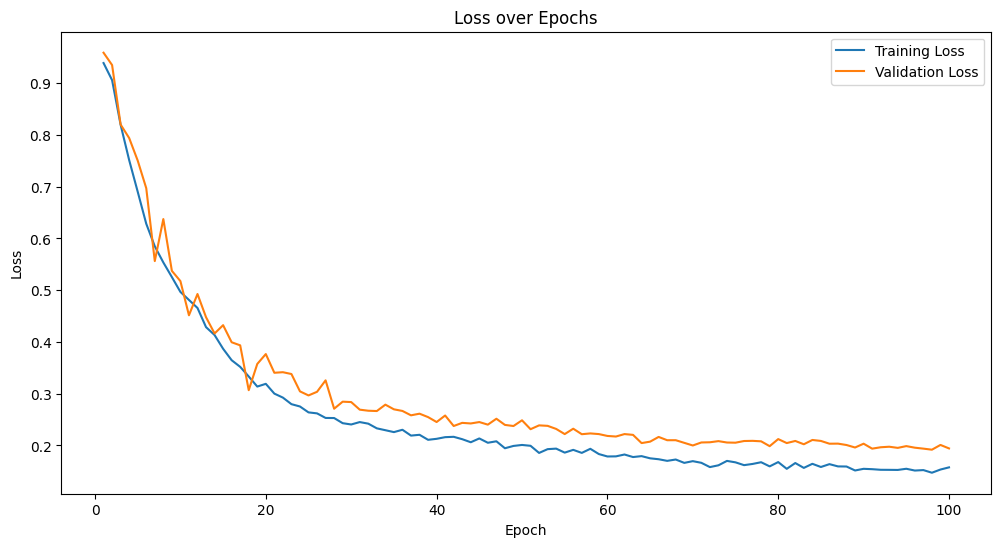

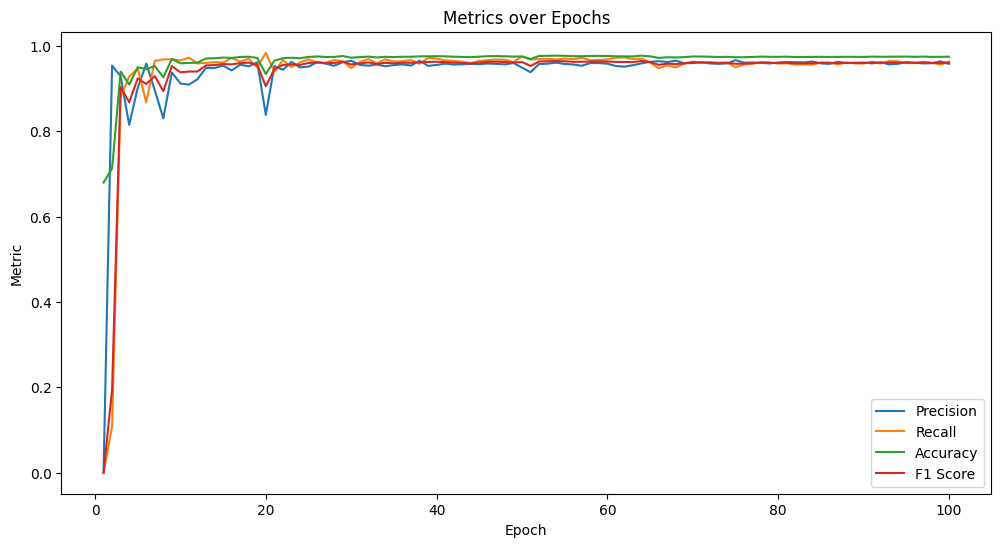

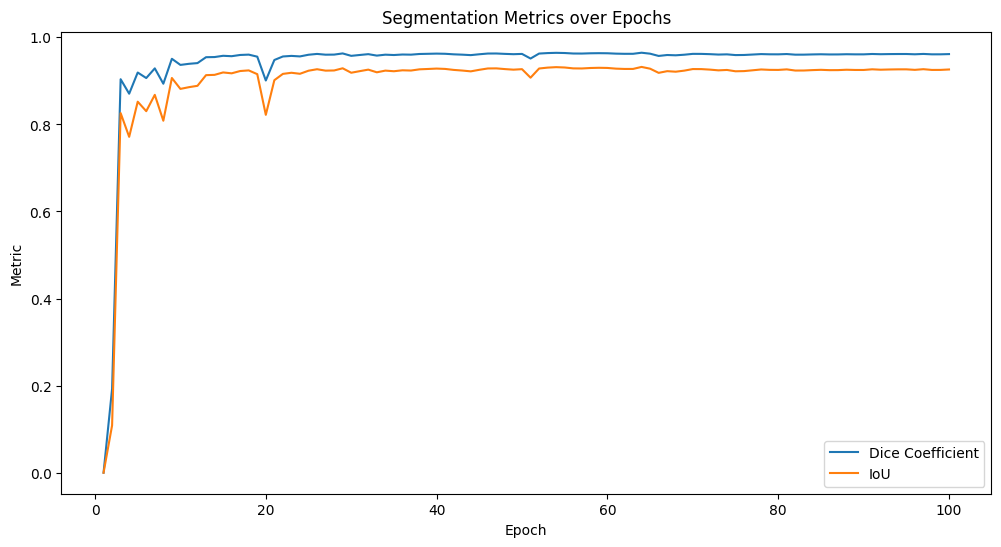

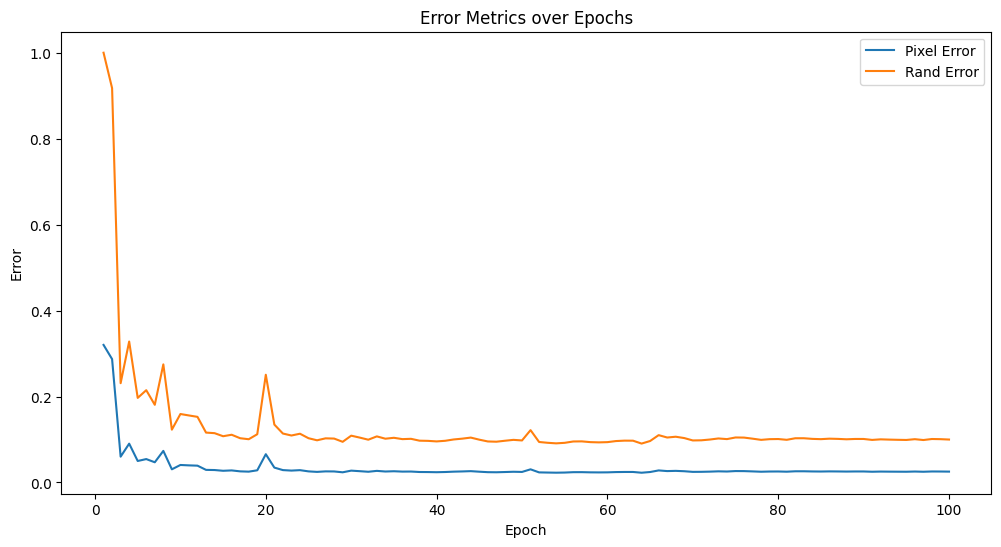

In [14]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_data, label='Training Loss')
plt.plot(epochs, val_loss_data, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.savefig('loss.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_data, label='Precision')
plt.plot(epochs, recall_data, label='Recall')
plt.plot(epochs, accuracy_data, label='Accuracy')
plt.plot(epochs, f1_data, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Metrics over Epochs')
plt.savefig('metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, dice_coeff_data, label='Dice Coefficient')
plt.plot(epochs, iou_data, label='IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Segmentation Metrics over Epochs')
plt.savefig('segmentation_metrics.png')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(epochs, pixel_error_data, label='Pixel Error')
plt.plot(epochs, rand_error_data, label='Rand Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title('Error Metrics over Epochs')
plt.savefig('error_metrics.png')
plt.show()



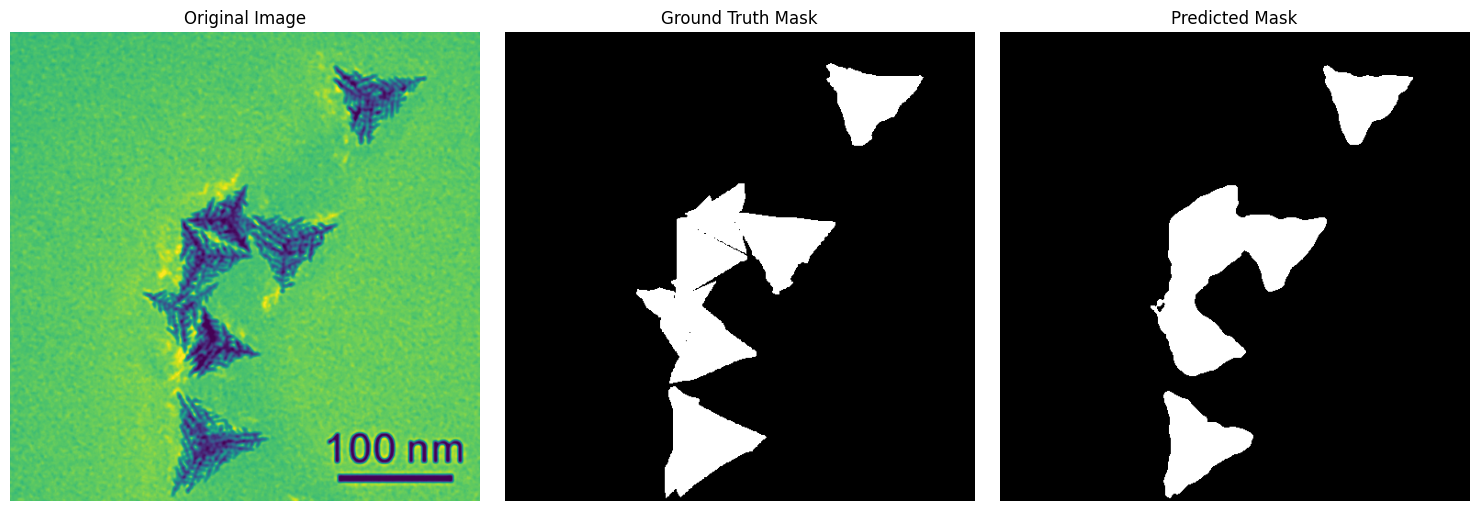

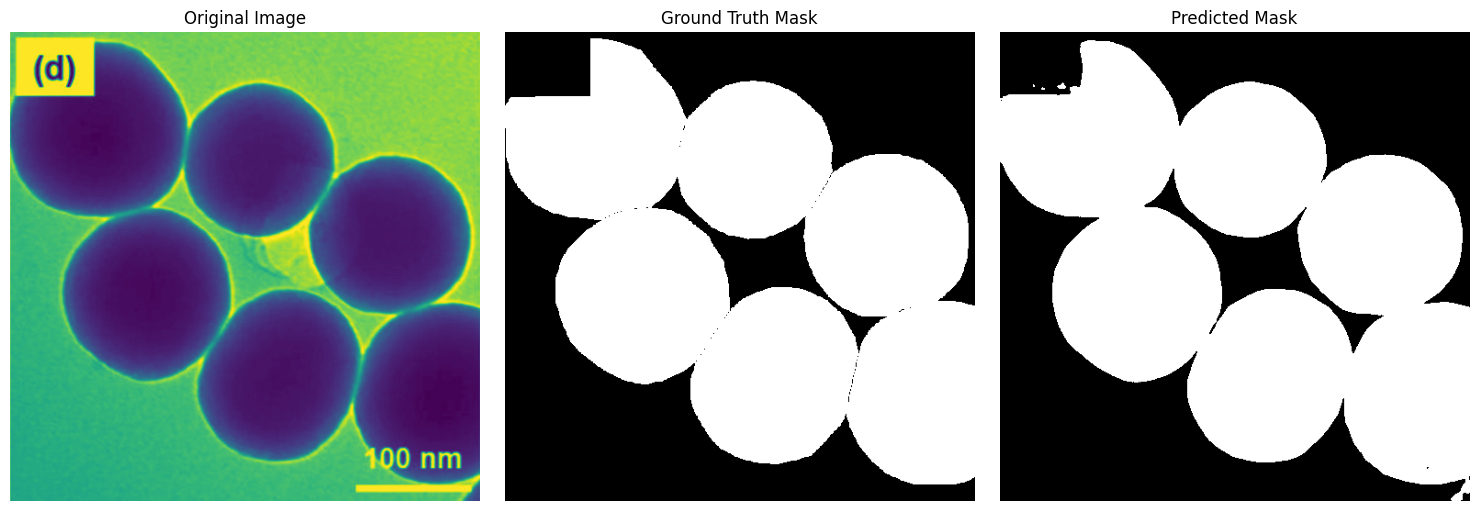

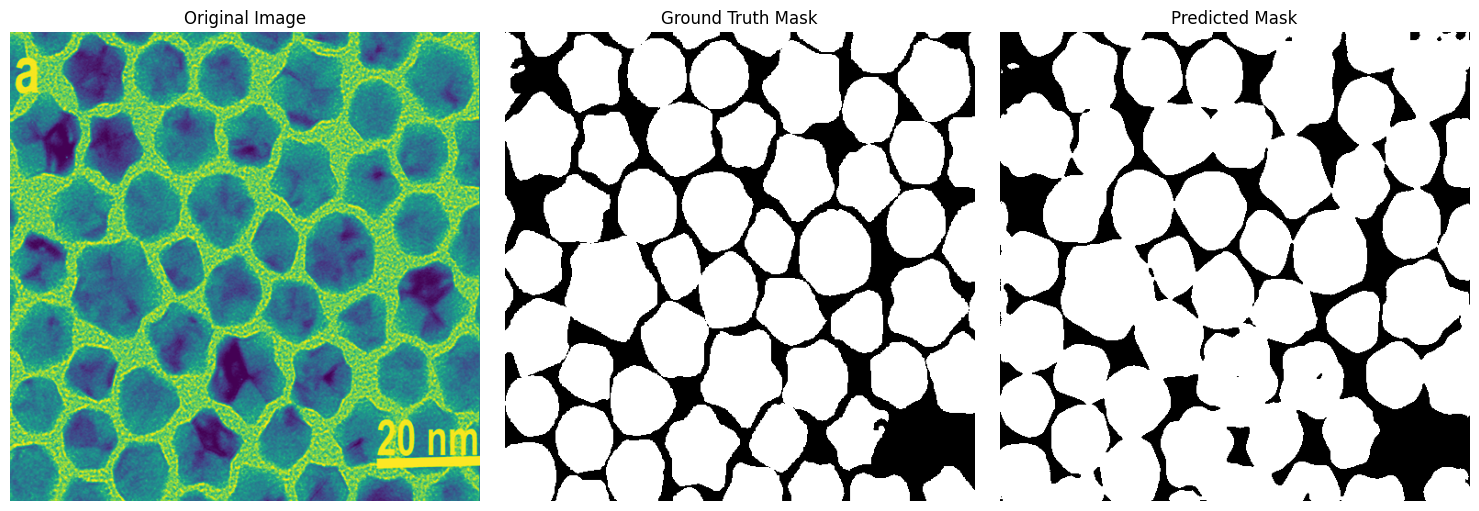

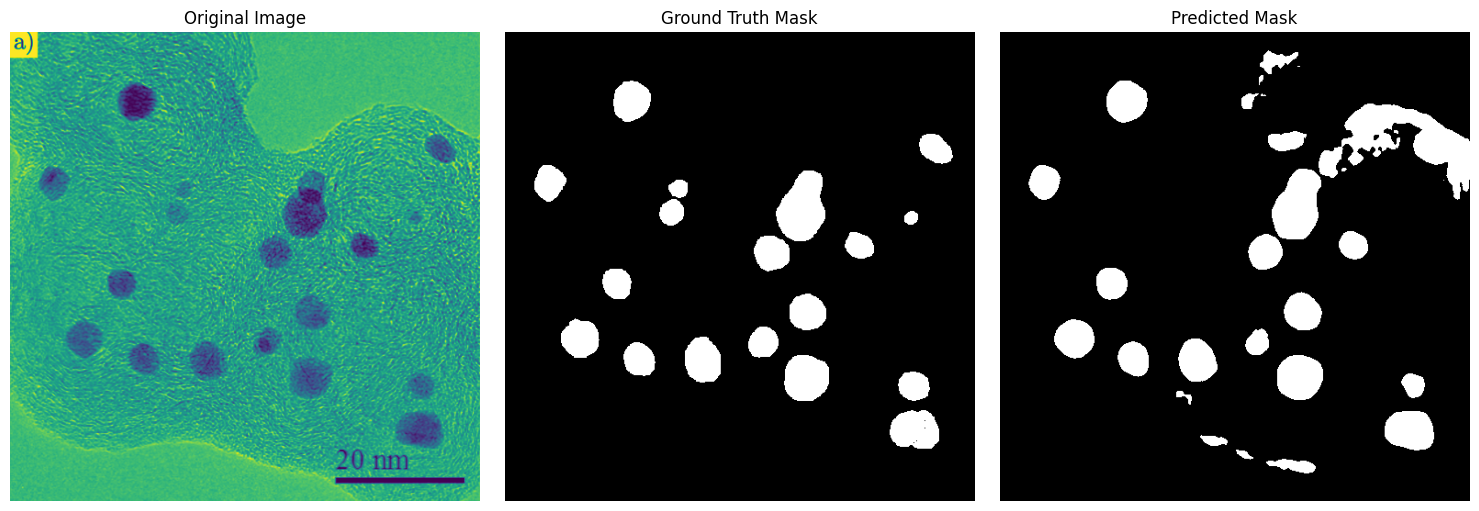

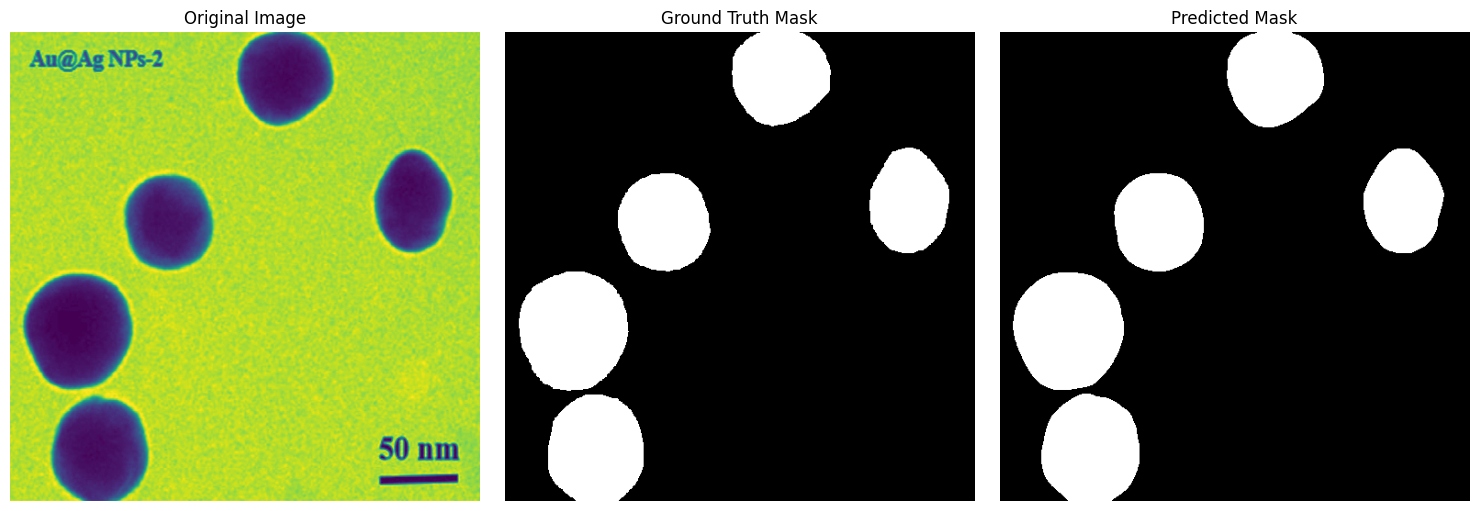

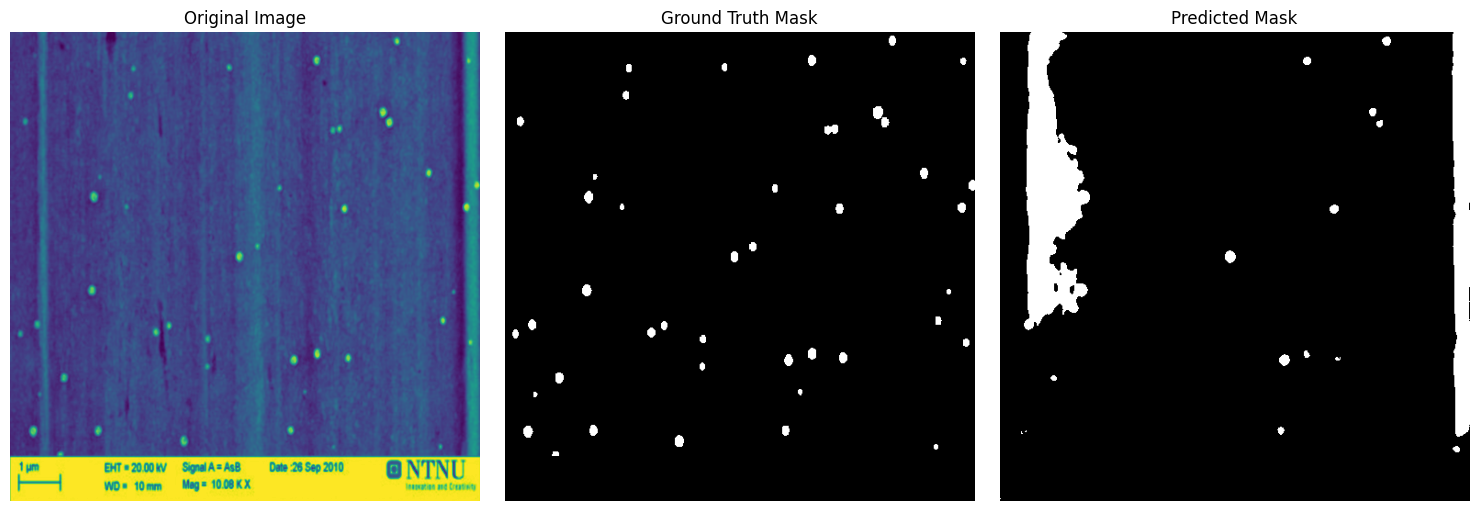

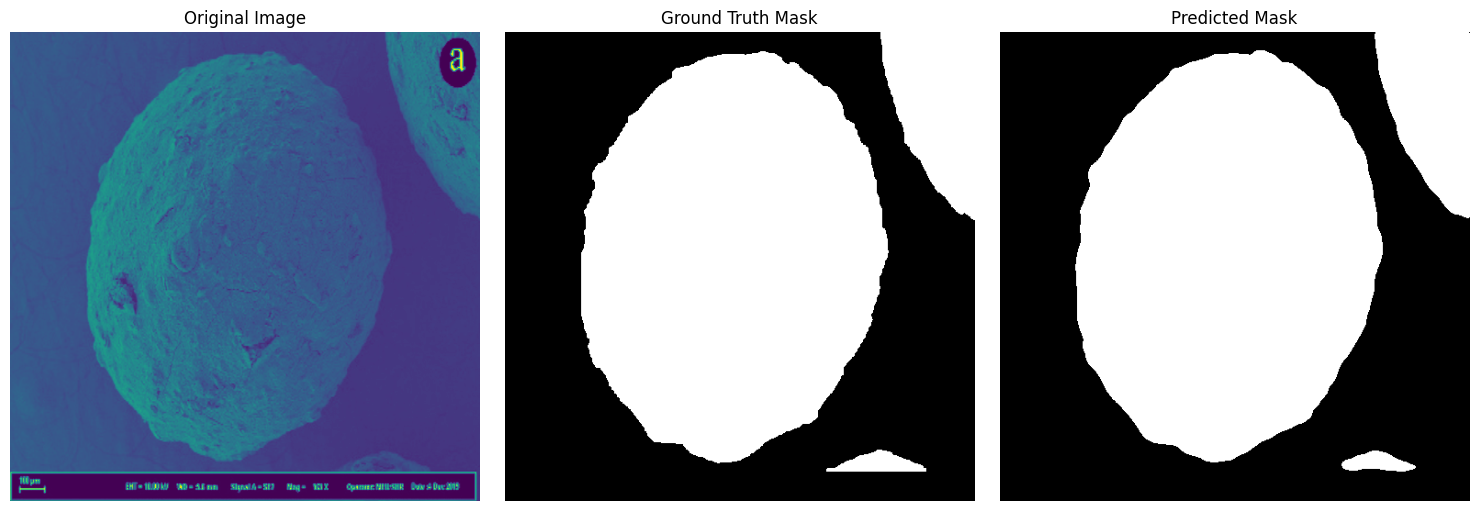

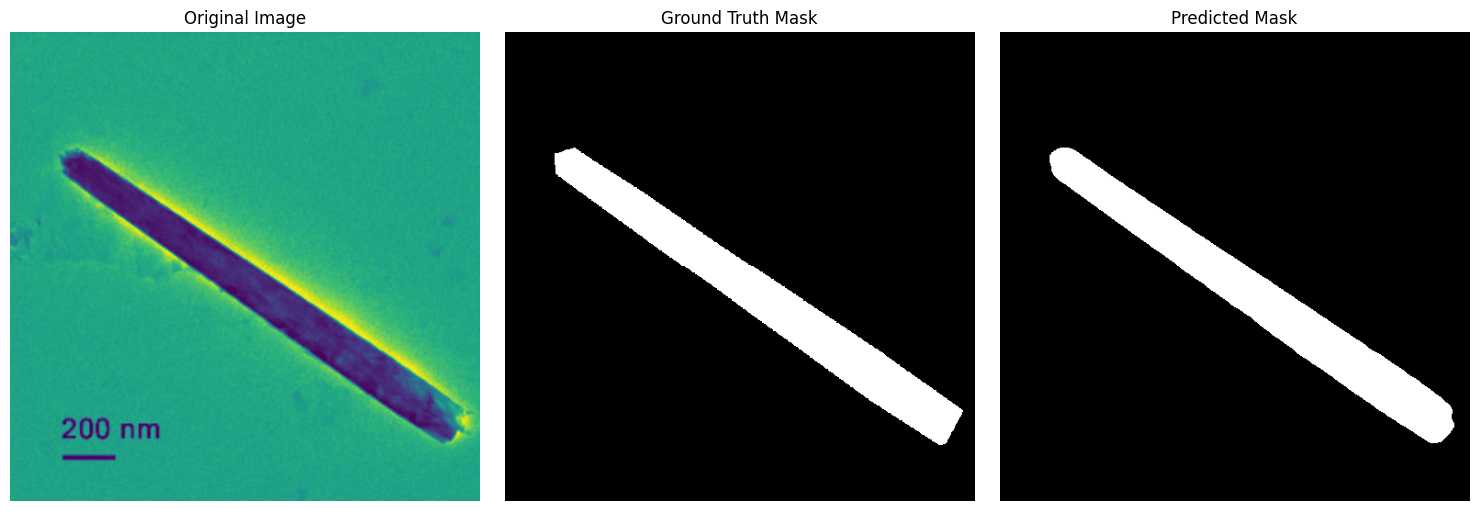

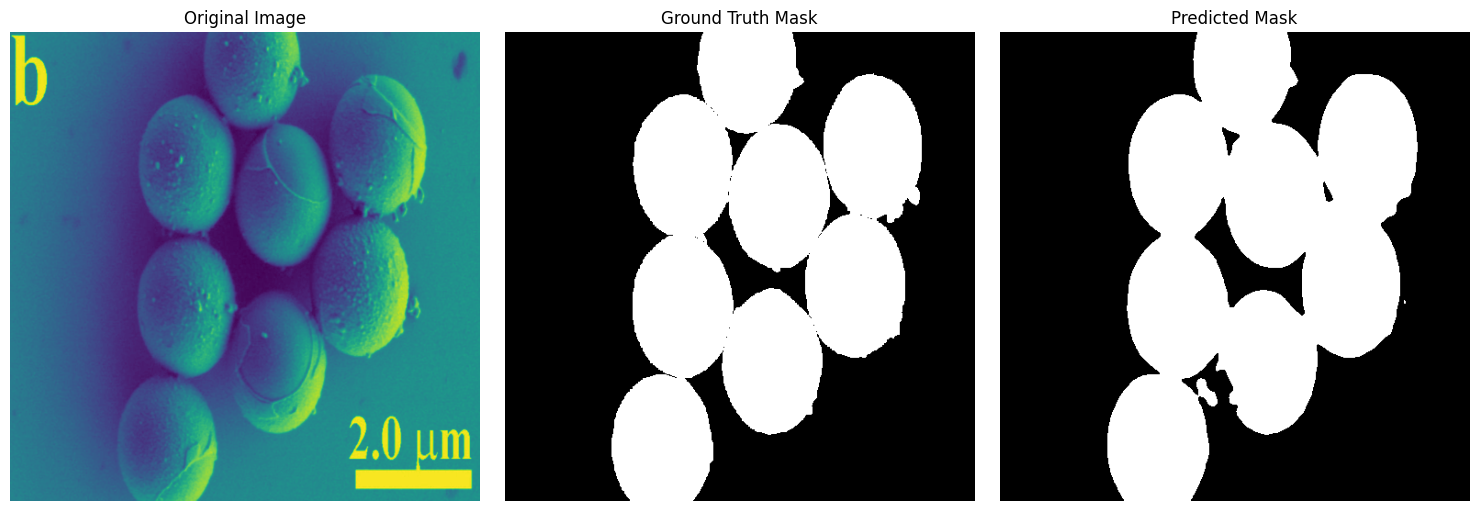

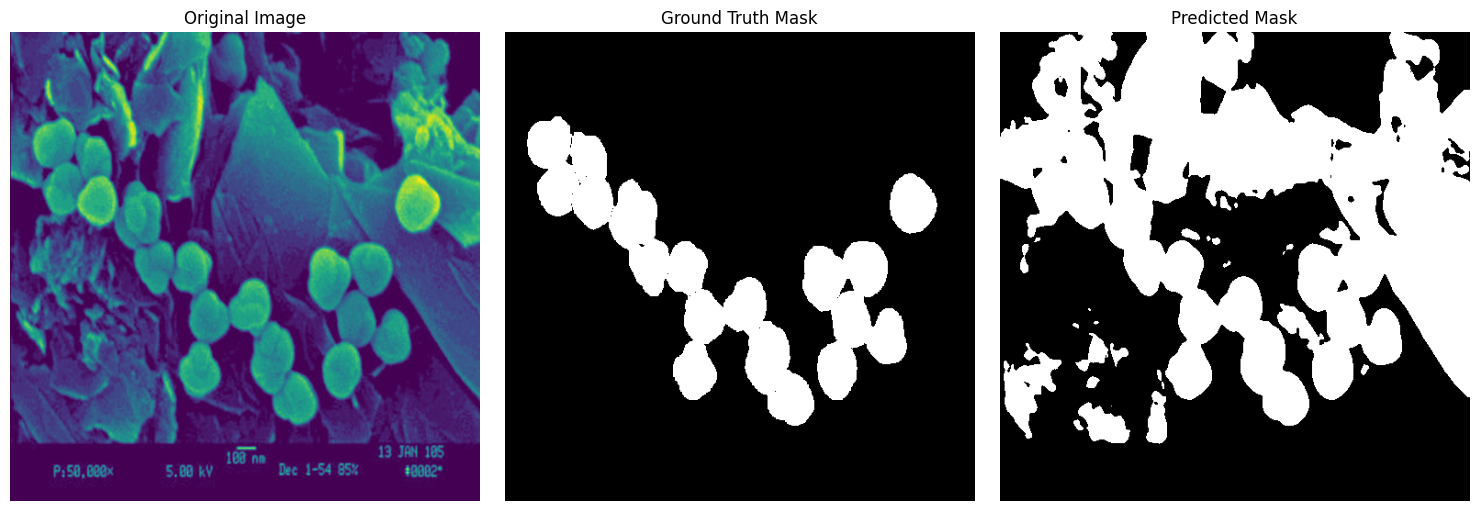

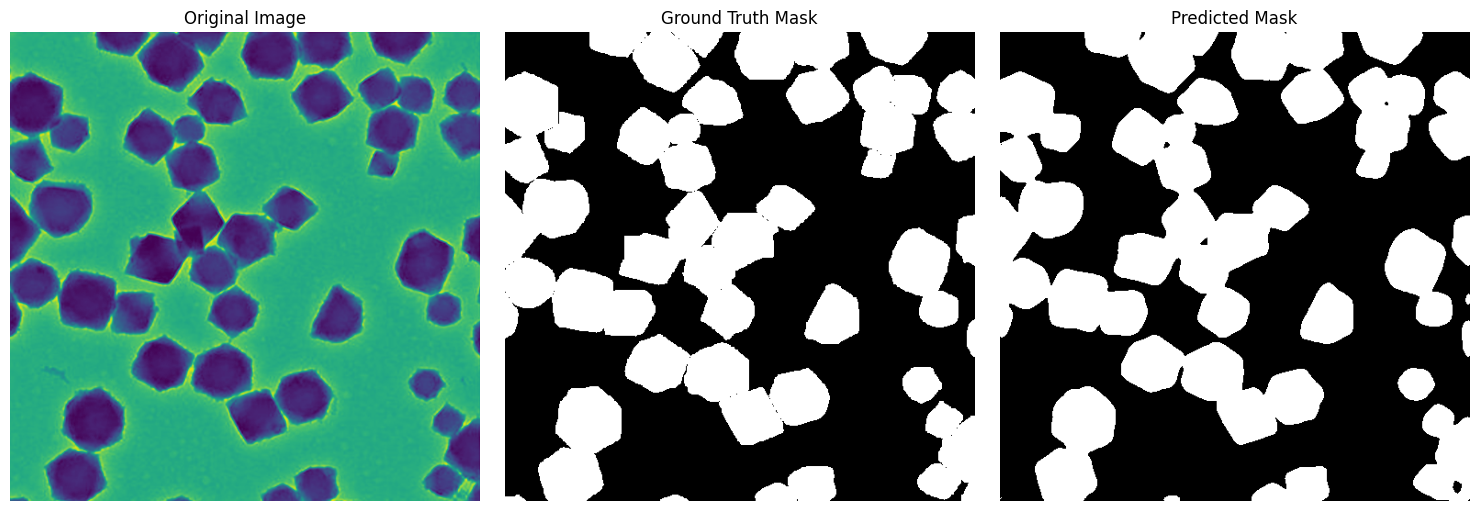

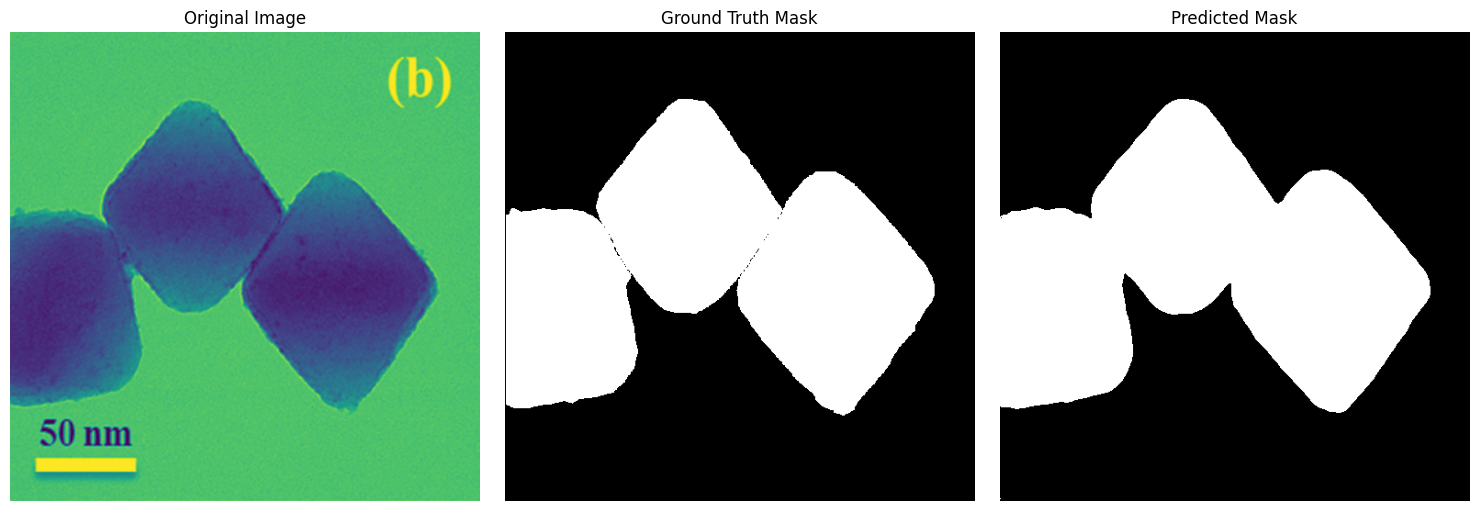

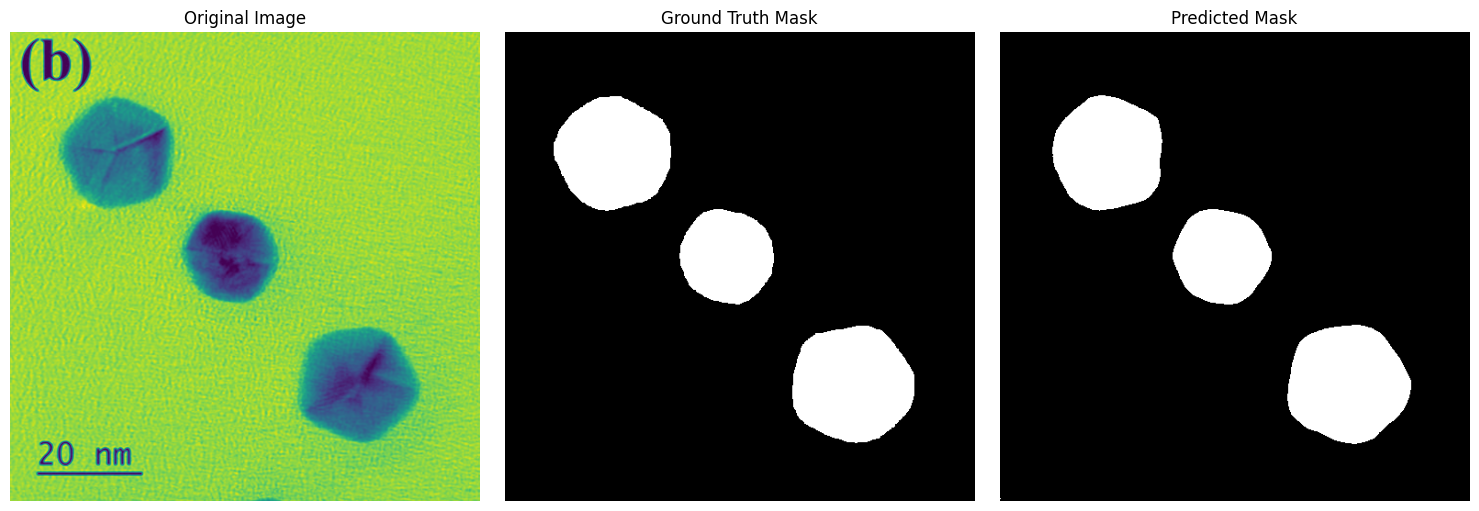

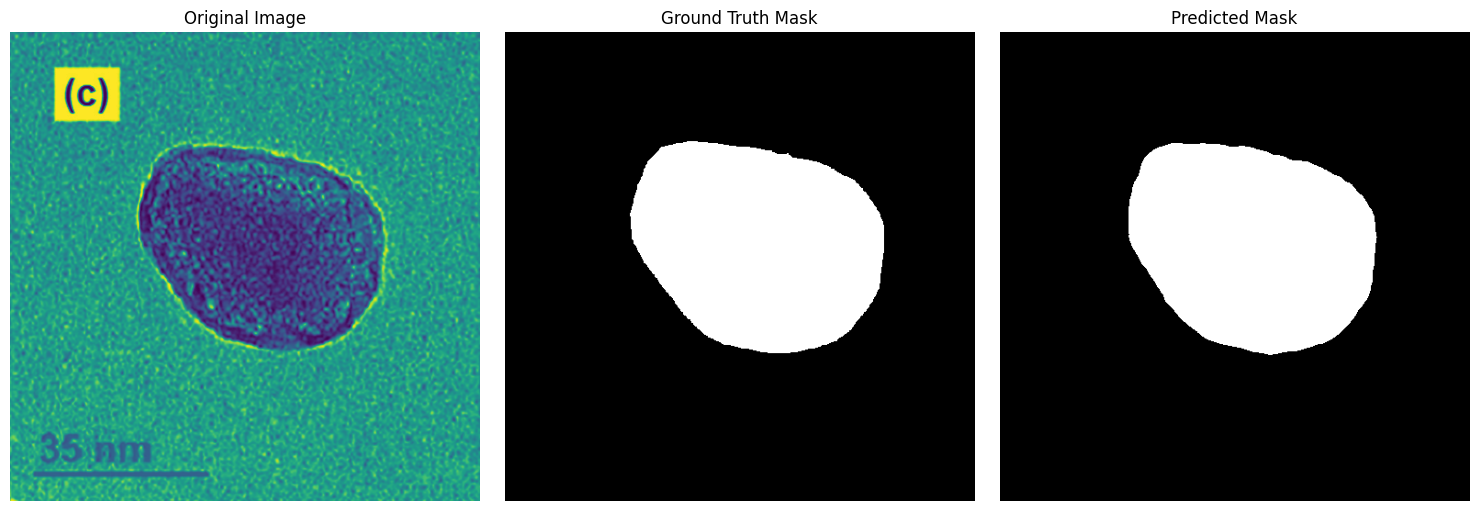

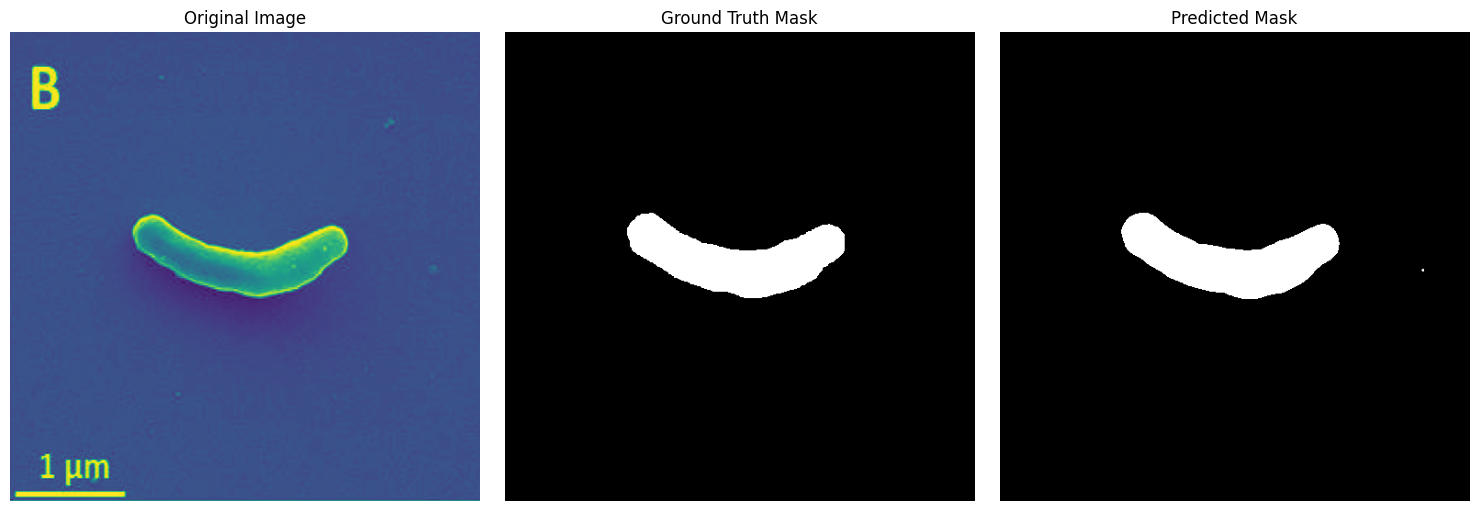

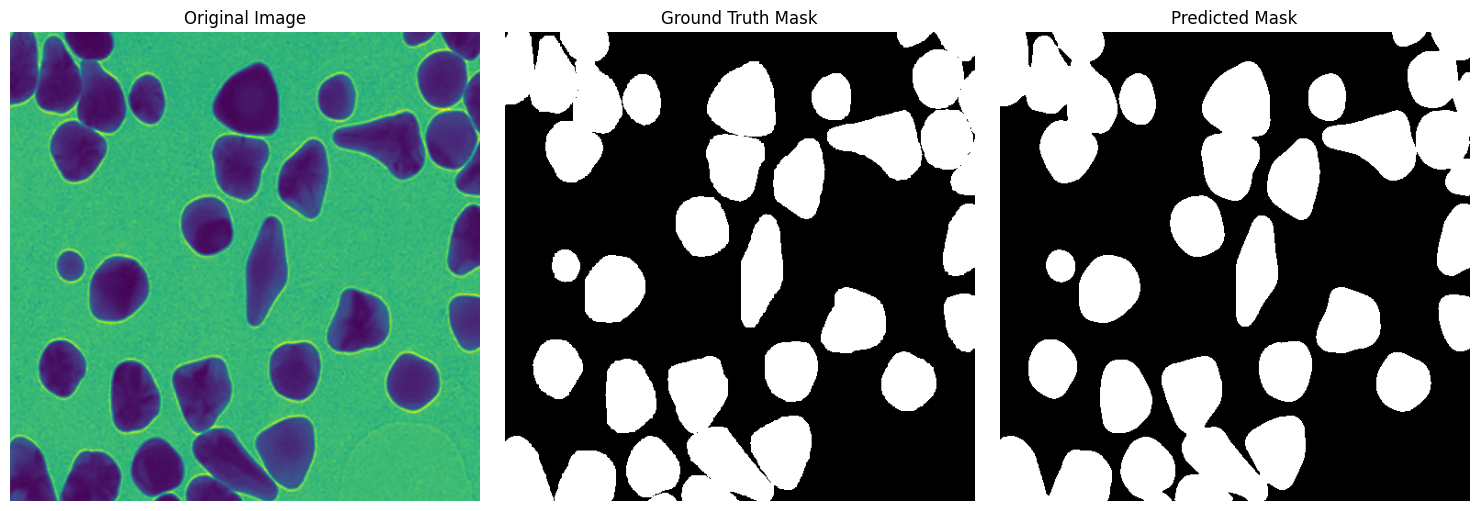

In [15]:
# Set the model to evaluation mode
model.eval()

# Get a batch of images and masks from the test loader
images, masks = next(iter(test_loader))
images = images.to(config.device)
masks = masks.to(config.device)

# Run the model on the images
with torch.no_grad():
    outputs = model(images)
    if isinstance(outputs, dict):
        outputs = outputs['out']
    outputs = outputs.squeeze(1)  # Remove channel dimension if necessary

    # Apply sigmoid activation to get probabilities between 0 and 1
    probs = torch.sigmoid(outputs)

# Threshold probabilities to get binary masks
pred_masks = (probs > 0.5).float()

# Move data to CPU and convert to NumPy arrays for plotting
images = images.cpu()
masks = masks.cpu()
pred_masks = pred_masks.cpu()

# Denormalize images for visualization if you normalized them during preprocessing
mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
std = np.array([0.229, 0.224, 0.225])   # ImageNet std

batch_size = images.shape[0]

for i in range(batch_size):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    img = images[i].permute(1, 2, 0).numpy()  # Change shape from [C, H, W] to [H, W, C]
    #img = img * std + mean  # Denormalize
    #img = np.clip(img, 0, 1)  # Clip values to [0, 1] range
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Ground Truth Mask
    gt_mask = masks[i].numpy()
    ax[1].imshow(gt_mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    # Predicted Mask
    pred_mask = pred_masks[i].numpy()
    ax[2].imshow(pred_mask, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')
    #plt.savefig(f"epoch_{epoch+1}_image_{i}.png")
    plt.tight_layout()
    plt.show()


In [16]:
import pandas as pd
data = {
    "epoch": epochs,
    "train_loss": train_loss_data,
    "val_loss": val_loss_data,
    "precision": precision_data,
    "recall": recall_data,
    "accuracy": accuracy_data,
    "iou": iou_data,
    "f1": f1_data,
    "dice_coeff": dice_coeff_data,
    "rand_error": rand_error_data,
    "pixel_error": pixel_error_data
}

metrics_df = pd.DataFrame(data)
print(metrics_df)
metrics_df.to_csv("training_metrics.csv", index=False)

    epoch  train_loss  val_loss  precision    recall  accuracy           iou  \
0       1    0.938776  0.958689   0.000000  0.000000  0.679865  8.234864e-13   
1       2    0.905707  0.934882   0.953924  0.108487  0.712918  1.086619e-01   
2       3    0.819343  0.819908   0.928666  0.879923  0.939921  8.260246e-01   
3       4    0.751190  0.793860   0.815106  0.928263  0.909626  7.714769e-01   
4       5    0.690147  0.750287   0.901698  0.946965  0.949972  8.521748e-01   
..    ...         ...       ...        ...       ...       ...           ...   
95     96    0.151523  0.195689   0.960614  0.959700  0.974502  9.253310e-01   
96     97    0.152405  0.193855   0.959023  0.963067  0.975003  9.268526e-01   
97     98    0.147323  0.191814   0.959473  0.960516  0.974372  9.251484e-01   
98     99    0.153482  0.201004   0.963852  0.956114  0.974471  9.252083e-01   
99    100    0.157669  0.194277   0.957969  0.963226  0.974698  9.261901e-01   

          f1    dice_coeff  rand_error 